In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from uszipcode import SearchEngine

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 22})
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

## Map ZIP code to market

In [3]:
zipcode_to_market_area_mapping_df = pd.read_csv('zipcode_to_rex_market_area_mapping_raw.csv')
zipcode_to_market_area_mapping_df['zipcode'] = zipcode_to_market_area_mapping_df['zipcode'].astype(str)
zipcode_to_market_area_mapping_df['zipcode'] = zipcode_to_market_area_mapping_df['zipcode'].str.pad(
    5, 'left', '0')

In [4]:
rex_market_areas = zipcode_to_market_area_mapping_df['market_area'].unique()

In [5]:
nj_zipcodes = zipcode_to_market_area_mapping_df[
    zipcode_to_market_area_mapping_df['market_area'] == 'NJ']['zipcode']

In [6]:
search = SearchEngine(simple_zipcode=True)
lst = []
for zipcode in nj_zipcodes:
    county = search.by_zipcode(zipcode).to_dict()['county']
    if county:
        county = county.split()[0]
        lst.append([zipcode, county])

nj_zipcode_to_location_df = pd.DataFrame(lst, columns=['zipcode', 'county'])

In [7]:
nj_zipcode_to_location_df.head()

,zipcode,county
0,07001,Middlesex
1,07002,Hudson
2,07003,Essex
3,07004,Essex
4,07005,Morris


In [8]:
mls_metro_area_to_counties = {
    'Camden': ['Camden', 'Burlington', 'Gloucester', 'Mercer', 'Cumberland'],
    'Jersey Shore': ['Ocean', 'Monmouth'],
}

lst = []
for mls_metro_area, counties in mls_metro_area_to_counties.items():
    for county in counties:
        lst.append([county, mls_metro_area])
        
county_to_market_area = pd.DataFrame(lst, columns=['county', 'nj_market_area'])

In [9]:
nj_zipcode_to_market_area_df = nj_zipcode_to_location_df[['zipcode', 'county']].merge(
    county_to_market_area, how='left')[['zipcode', 'nj_market_area']]

In [10]:
zipcode_to_market_area_mapping_df = zipcode_to_market_area_mapping_df.merge(
    nj_zipcode_to_market_area_df, on='zipcode', how='left')

In [11]:
zipcode_to_market_area_mapping_df.head()

,zipcode,market_area,nj_market_area
0,00501,NY,NaN
1,00544,NY,NaN
2,01005,Boston,NaN
3,01031,Boston,NaN
4,01037,Boston,NaN


In [12]:
zipcode_to_market_area_mapping_df['market_area'] = (
    zipcode_to_market_area_mapping_df['nj_market_area'].combine_first(
    zipcode_to_market_area_mapping_df['market_area'])
)
zipcode_to_market_area_mapping_df.drop(columns=['nj_market_area'], inplace=True)

In [13]:
zipcode_to_market_area_mapping_df['market_area'].replace('NJ', 'rest_of_NJ', inplace=True)

In [14]:
zipcode_to_metro_area_mapping_df = pd.read_csv('zipcode_to_metro_area_mapping.csv')
zipcode_to_metro_area_mapping_df.rename(columns={'metro_area': 'market_area'}, inplace=True)
zipcode_to_metro_area_mapping_df['zipcode'] = zipcode_to_metro_area_mapping_df['zipcode'].astype(str)
zipcode_to_metro_area_mapping_df['zipcode'] = zipcode_to_metro_area_mapping_df['zipcode'].str.pad(5, 'left', '0')

In [15]:
lst = [('15265', 'Pittsburgh'),
        ('16261', 'Pittsburgh'),
        ('06235', 'Hartford')]
zipcode_to_market_area_mapping_df2 = pd.DataFrame(lst, columns=['zipcode', 'market_area'])

In [16]:
zipcode_to_market_area_mapping_df = pd.concat(
    [zipcode_to_market_area_mapping_df, zipcode_to_metro_area_mapping_df, zipcode_to_market_area_mapping_df2])

In [17]:
zipcode_to_market_area_mapping_df.sort_values('market_area', inplace=True)
zipcode_to_market_area_mapping_df.drop_duplicates(subset=['zipcode'], keep='first', inplace=True)

## Process buy-side commission info

In [18]:
buyer_commission_df = pd.read_csv('redfin_data_subset_of_columns.csv')
buyer_commission_df['zipcode'] = buyer_commission_df['zipcode'].astype(str)
buyer_commission_df['zipcode'] = buyer_commission_df['zipcode'].str.pad(
    5, 'left', '0')

In [19]:
buyer_commission_df['brokerage'] = buyer_commission_df['brokerage'].apply(
    lambda x: x.lower() if pd.notnull(x) else x)

In [20]:
buyer_commission_df['nonnull_commission'] = buyer_commission_df['buyside_commission'].apply(
    lambda x: int(pd.notnull(x)))

In [21]:
# keep the latest non-null buy-side commission offered by the seller
buyer_commission_df.sort_values(['nonnull_commission', 'created_date'], ascending=[False, False], inplace=True)
len(buyer_commission_df)

21097650

In [22]:
# remove duplicate listings
buyer_commission_df.drop_duplicates(subset=['external_id'], keep='first', inplace=True)
len(buyer_commission_df)

2191839

In [23]:
# there are some rows that have the same address + zipcode but have a different external_id so we also 
# want to remove these duplicate listings
buyer_commission_df.drop_duplicates(subset=['address', 'zipcode'], keep='first', inplace=True)
len(buyer_commission_df)

2103835

In [24]:
# get market area in which each listing resides
buyer_commission_df = buyer_commission_df.merge(zipcode_to_market_area_mapping_df, on='zipcode', how='left')

In [25]:
print(len(buyer_commission_df))
buyer_commission_df = buyer_commission_df[buyer_commission_df['market_area'].notna()]
print(len(buyer_commission_df))

2103835
2103835


In [26]:
buyer_commission_df.replace(
    {'market_area': 
     {'SD': 'San Diego', 
      'OC': 'Orange County',
      'DMV': 'DC metro area',
      'Bend': 'Bend, OR',
      'Portland': 'Portland, OR',
      'LA': 'Los Angeles',
      'Research-Triangle': 'Research Triangle',
      'Santa Maria': 'Santa Maria, CA'}}, inplace=True)

In [27]:
# get listings with non-null buyer's agent commission
buyer_commission_df_nonnull = buyer_commission_df[buyer_commission_df['buyside_commission'].notna()]

In [28]:
# get summary statistic for each market area (number of listings, number of listings with commission data,
# fraction of listings with commission data)
lst_of_lsts = []
for market_area in buyer_commission_df_nonnull['market_area'].unique():
    market_area_df = buyer_commission_df[buyer_commission_df['market_area'] == market_area]
    nonull_df = buyer_commission_df_nonnull[buyer_commission_df_nonnull['market_area'] == market_area]
    lst_of_lsts.append([market_area, len(market_area_df), len(nonull_df), len(nonull_df) / len(market_area_df)])

columns = ['market_area', 'listing_count', 'nonnull_commission_count', 'nonnull_fraction_of_listings']
summary_df = pd.DataFrame(lst_of_lsts, columns=columns)
summary_df.sort_values('nonnull_fraction_of_listings', ascending=False, inplace=True)

In [29]:
summary_df

,market_area,listing_count,nonnull_commission_count,nonnull_fraction_of_listings
40,Anchorage,4943,4815,0.974105
33,Kansas City,20912,20222,0.967005
32,St. Louis,25798,24894,0.964959
7,Camden,26677,25659,0.961840
8,Jersey Shore,25165,24162,0.960143
1,DC metro area,79159,75914,0.959007
35,Indianapolis,20627,19726,0.956319
9,Virginia Beach,16808,16061,0.955557
22,Orange County,27816,26558,0.954774
18,Houston,96324,91860,0.953656


In [30]:
buyer_commission_df_nonnull.shape

(1197945, 9)

In [31]:
# remove egregiously high buy-side commissions
max_commission = np.quantile(buyer_commission_df_nonnull['buyside_commission'], 0.995)

buyer_commission_df_nonnull = buyer_commission_df_nonnull[
    buyer_commission_df_nonnull['buyside_commission'] <= max_commission
]

In [32]:
len(buyer_commission_df_nonnull)

1194715

In [33]:
max_commission

5.0

In [34]:
# https://www.builderonline.com/builder-100/builder-100-list/2021/
top_100_homebuilder_brokerages = [
    'dr horton', 'drhorton', 'd r horton', 'd r  horton', 
    'lennar',
    'pulte', 
    'nvr services, inc.',
    'kb home', 
    'taylor morrison',
    'meritage',
    'toll brothers',
    'century communities',
    'lgi',
    'mdc',
    'm/i',
    'beazer',
    'k hovnanian',
    'tri pointe homes',
    'david weekley homes',
    'william lyon homes',
    'ashton woods realty',
    'clayton properties',
    'shea homes',
    'mattamy',
    'highland homes realty',
    'perry development management',
    'gehan homes',
    'drb group',
    'brookfield',
    'woodside homes',
    'drees homes',
    'landsea',
    'epcon',
    'kolter homes',
    'history maker homes',
    'american legend homes',
    'stylecraft builders',
    'american classic',
    'pacesetter homes',
    'empire communities'
]

additional_homebuilder_brokerages = [
    'riverway builders austin, llc',
    'brock built properties',
    'storybuilt',
    'liberty home builders',
    'dan ryan builders',
    'builders realty network',
    'partners in building',
    'viera builders realty',
    'stylecraft builders',
    'intown builders',
    'pacific communities builder',
    'abercrombie builders',
    'maddock building and realty co',
    'custom home builders realty',
    'tnhc realty and construction',
    'city ventures construction',
    'cascadian south corp', 'cascadian king company llc',
    'homesusacom',
    'alexander properties'
]

homebuilder_brokerages = tuple(top_100_homebuilder_brokerages + additional_homebuilder_brokerages)

In [35]:
# remove new construction homes
def is_homebuilder(brokerage):
    return int(pd.notnull(brokerage) and brokerage.startswith(homebuilder_brokerages))

def was_just_built(year_built):
    return int(pd.notnull(year_built) and year_built >= 2020)
                            
buyer_commission_df_nonnull['homebuilder'] = buyer_commission_df_nonnull['brokerage'].apply(is_homebuilder)
buyer_commission_df_nonnull['was_just_built'] = buyer_commission_df_nonnull['year_built'].apply(was_just_built)
buyer_commission_df_nonnull['null_year_built'] = buyer_commission_df_nonnull['year_built'].apply(
    lambda x: int(pd.isnull(x)))

In [36]:
buyer_commission_df_nonnull_f = buyer_commission_df_nonnull[
    (buyer_commission_df_nonnull['null_year_built'] == 0) &
    (buyer_commission_df_nonnull['was_just_built'] == 0) &
    (buyer_commission_df_nonnull['homebuilder'] == 0)
]

In [37]:
len(buyer_commission_df_nonnull_f) / len(buyer_commission_df_nonnull)

0.8421112985105235

In [38]:
buyer_commission_df_nonnull_f.shape

(1006083, 12)

## Report results

In [39]:
market_area_to_df = {}
lst = []
top_num = 10
for market_area in sorted(buyer_commission_df_nonnull_f['market_area'].unique()):
    market_area_df = buyer_commission_df_nonnull_f[
        buyer_commission_df_nonnull_f['market_area'] == market_area]
    over_3_df = market_area_df[market_area_df['buyside_commission'] > 3.0]
    at_least_3_df = market_area_df[market_area_df['buyside_commission'] >= 3.0]
    under_2_df = market_area_df[market_area_df['buyside_commission'] < 2.0]
    under_1_df = market_area_df[market_area_df['buyside_commission'] <= 1.0]
    pct_over_3 = len(over_3_df) / len(market_area_df)
    pct_at_least_3 = len(at_least_3_df) / len(market_area_df)
    pct_under_2 = len(under_2_df) / len(market_area_df)
    mean = market_area_df['buyside_commission'].mean()

    value_counts = market_area_df['buyside_commission'].value_counts()
    top_value_counts = value_counts.iloc[:top_num]
    top_value_fracs = top_value_counts / len(market_area_df)
    single_value_pct = list(top_value_fracs)[0]
    double_value_pct = sum(list(top_value_fracs)[0:2])
    under_going_rate = market_area_df[
        market_area_df['buyside_commission'] < top_value_counts.index[0]]
    under_going_rate_pct = len(under_going_rate) / len(market_area_df)
    df = pd.DataFrame.from_dict({'number of listings': list(top_value_counts), 
                                 'fraction of listings': list(top_value_fracs)})
    df['commission percentage'] = top_value_counts.index
    df = df[['commission percentage', 'number of listings', 'fraction of listings']]
    market_area_to_df[market_area] = df

    lst.append([market_area, len(market_area_df), mean, 100 * pct_over_3, 
                100 * pct_at_least_3, 100 * pct_under_2, 
                top_value_counts.index[0], top_value_counts.index[1], 
                100 * single_value_pct, 100 * double_value_pct, 100 * under_going_rate_pct])

columns = ['market_area', 'listings', 'mean', 'pct_over_3', 'pct_at_least_3', 'pct_under_2', 'top_rate', 
           '2nd_top_rate', 'top_rate_pct', 'top_2_rates_pct', 'pct_under_going_rate']
market_area_summary_stats_df = pd.DataFrame(lst, columns=columns)

In [40]:
market_area_summary_stats_df.head()

,market_area,listings,mean,pct_over_3,pct_at_least_3,pct_under_2,top_rate,2nd_top_rate,top_rate_pct,top_2_rates_pct,pct_under_going_rate
0,Anchorage,3040,2.683490,1.546053,34.375000,0.361842,2.5,3.0,61.546053,94.375000,2.500000
1,Atlanta,52600,2.863827,0.623574,77.593156,0.336502,3.0,2.5,76.969582,88.768061,22.406844
2,Austin,26523,2.925989,0.064095,87.275195,0.214908,3.0,2.5,87.211100,97.485202,12.724805
3,Bakersfield,647,2.329706,0.772798,8.346213,3.091190,2.5,2.0,46.213292,80.834621,45.440495
4,Bay Area,1370,2.411175,0.364964,1.678832,5.328467,2.5,2.0,80.437956,91.678832,17.810219


## commission plots

In [41]:
# limit analysis to markets where the buy-side commission is reported on at least 5% of listings
market_areas_high_response = set(summary_df.loc[
    summary_df['nonnull_fraction_of_listings'] > 0.05, 'market_area'])

In [42]:
# also remove small REX markets
small_market_areas = {'Anchorage', 'Bend, OR', 'Boulder', 'Colorado Springs', 'Fort Collins', 'Jersey Shore',
                      'Omaha', 'Santa Maria, CA', 'Orange County', 'Camden', 'rest_of_NJ', 'Reno', 
                      'Bakersfield', 'Miami'
                      }
market_areas_high_response = {market_area for market_area in market_areas_high_response 
                              if market_area not in small_market_areas}

In [43]:
len(market_areas_high_response)

31

In [44]:
market_area_summary_stats_df_high_response = market_area_summary_stats_df[
    market_area_summary_stats_df['market_area'].isin(market_areas_high_response)
]

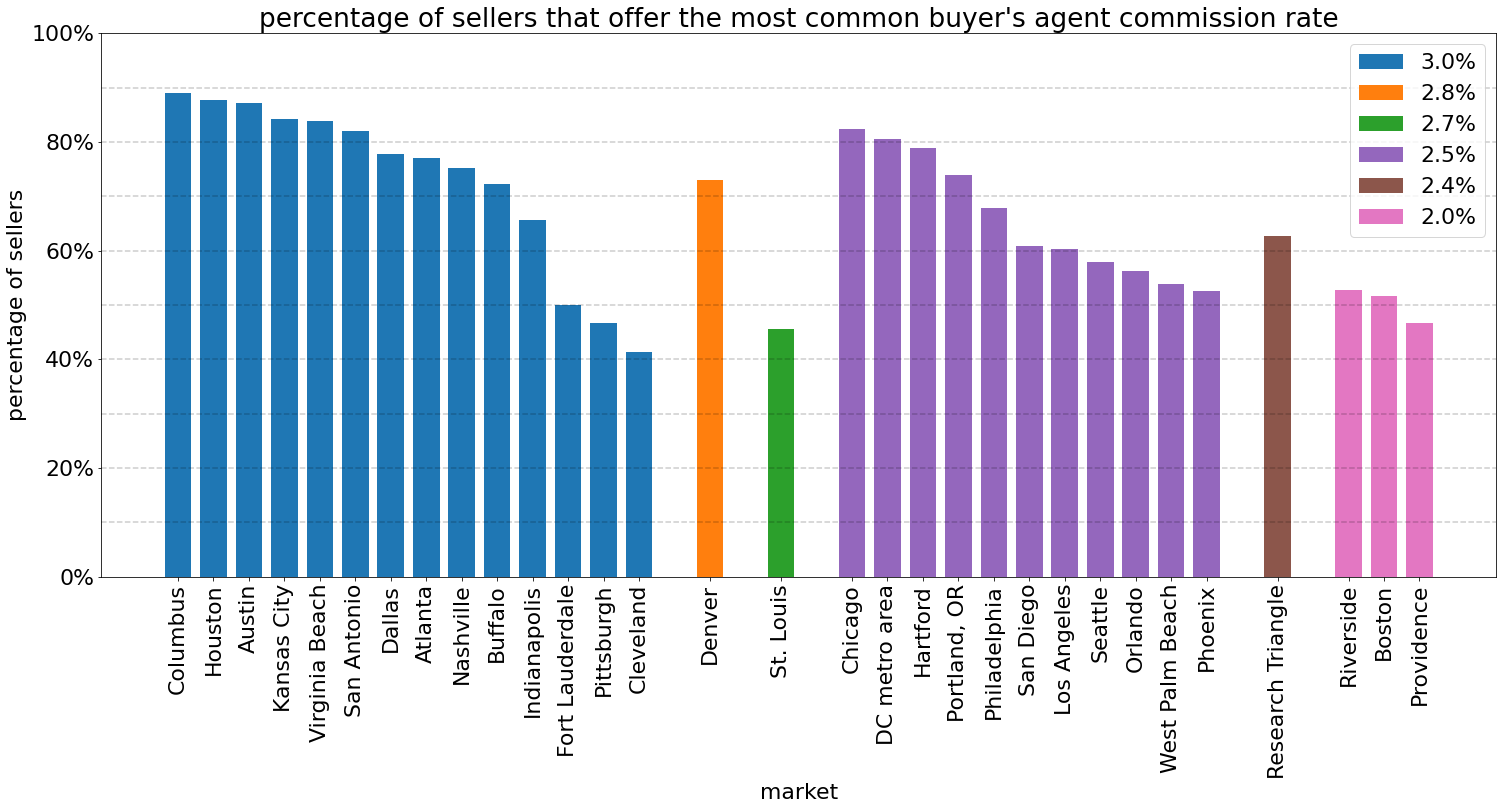

In [45]:
width = 0.6
plt.figure(figsize=(25, 10))
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
del default_colors[3]
x_pos_increment = 0.8
x_pos_gap = 1.6

cur_pos = 0
cnt = 0
market_areas = []
x_positions_lst = []
sorted_top_rates = market_area_summary_stats_df_high_response['top_rate'].sort_values(ascending=False).unique()
for top_rate in sorted_top_rates:
    df = market_area_summary_stats_df_high_response[
        market_area_summary_stats_df_high_response['top_rate'] == top_rate]
    df.sort_values('top_rate_pct', ascending=False, inplace=True)
    x_positions = [cur_pos + x_pos_increment * x for x in range(len(df))]
    plot = plt.bar(x_positions, list(df['top_rate_pct']), align='center', alpha=1.0, color=default_colors[cnt],
                   width=width, label=f'{top_rate}%')
    market_areas.extend(list(df['market_area']))
    x_positions_lst.extend(x_positions)
    cur_pos = x_positions[-1] + x_pos_gap
    cnt += 1

plt.xticks(x_positions_lst, market_areas, rotation=90)
plt.xlabel('market')
plt.ylabel('percentage of sellers')
for i in np.linspace(10, 90, 9):
    plt.axhline(y=i, color='k', linestyle='--', alpha=0.2)
plt.title("percentage of sellers that offer the most common buyer's agent commission rate")
plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
plt.ylim((0, 100))
plt.legend()
plt.show()

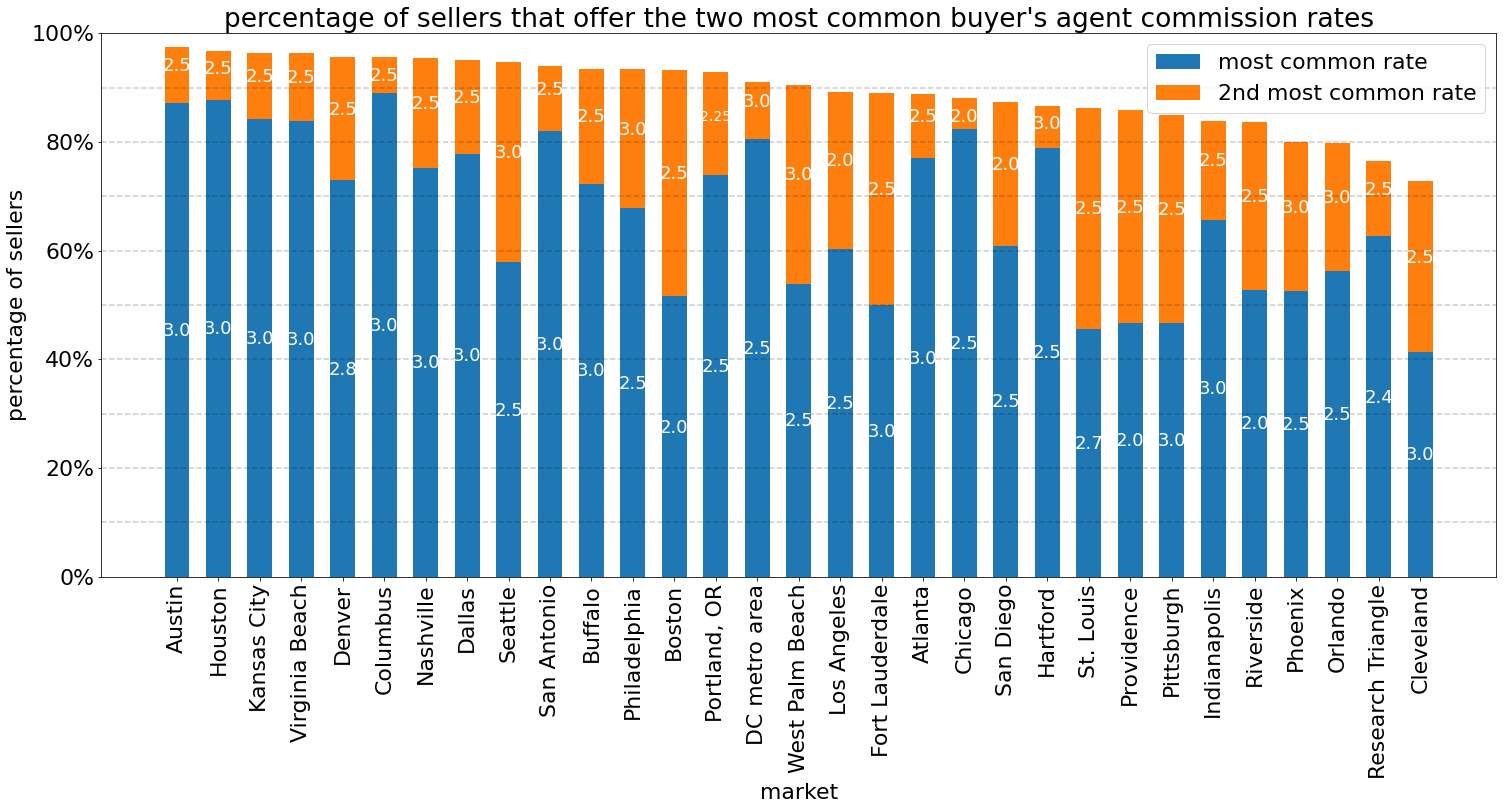

In [46]:
sorted_df = market_area_summary_stats_df_high_response.sort_values('top_2_rates_pct', ascending=False)
rate_pcts = list(sorted_df['top_rate_pct'])
top_commission_rates = list(sorted_df['top_rate'])
second_top_commission_rates = list(sorted_df['2nd_top_rate'])

plt.figure(figsize=(25, 10))
x_pos = np.arange(len(market_area_summary_stats_df_high_response))
plt.bar(x_pos, rate_pcts, align='center', alpha=1.0, width=width, label='most common rate')
lower_heights = [rate_pct / 2 for rate_pct in rate_pcts]
additional_pct = np.array(sorted_df['top_2_rates_pct'] - sorted_df['top_rate_pct'])
top_bar = plt.bar(x_pos, additional_pct, width=width, align='center', alpha=1.0, bottom=rate_pcts, 
                  label='2nd most common rate')
upper_heights = [rate_pcts[i] + additional_pct[i] / 2 for i in range(len(additional_pct))] 
plt.xticks(x_pos, list(sorted_df['market_area']), rotation=90)
plt.xlabel('market')
plt.ylabel('percentage of sellers')
for i in np.linspace(10, 90, 9):
    plt.axhline(y=i, color='k', linestyle='--', alpha=0.2)
    
top_2_rates_pct = list(sorted_df['top_2_rates_pct'])
for idx, rect in enumerate(top_bar):
    fontsize = 18
    plt.text(rect.get_x() + rect.get_width()/2., lower_heights[idx],
             top_commission_rates[idx], fontsize=fontsize,
             ha='center', va='bottom', rotation=0, color='white')
    upper_height = min(upper_heights[idx], top_2_rates_pct[idx] - 5)
    second_top_commission_rate = second_top_commission_rates[idx]
    if len(str(second_top_commission_rate)) > 3:
        fontsize = 14
    plt.text(rect.get_x() + rect.get_width()/2., upper_height,
             second_top_commission_rate, fontsize=fontsize,
             ha='center', va='bottom', rotation=0, color='white')
    
plt.ylim((0, 100))
plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.title("percentage of sellers that offer the two most common buyer's agent commission rates")
plt.show()

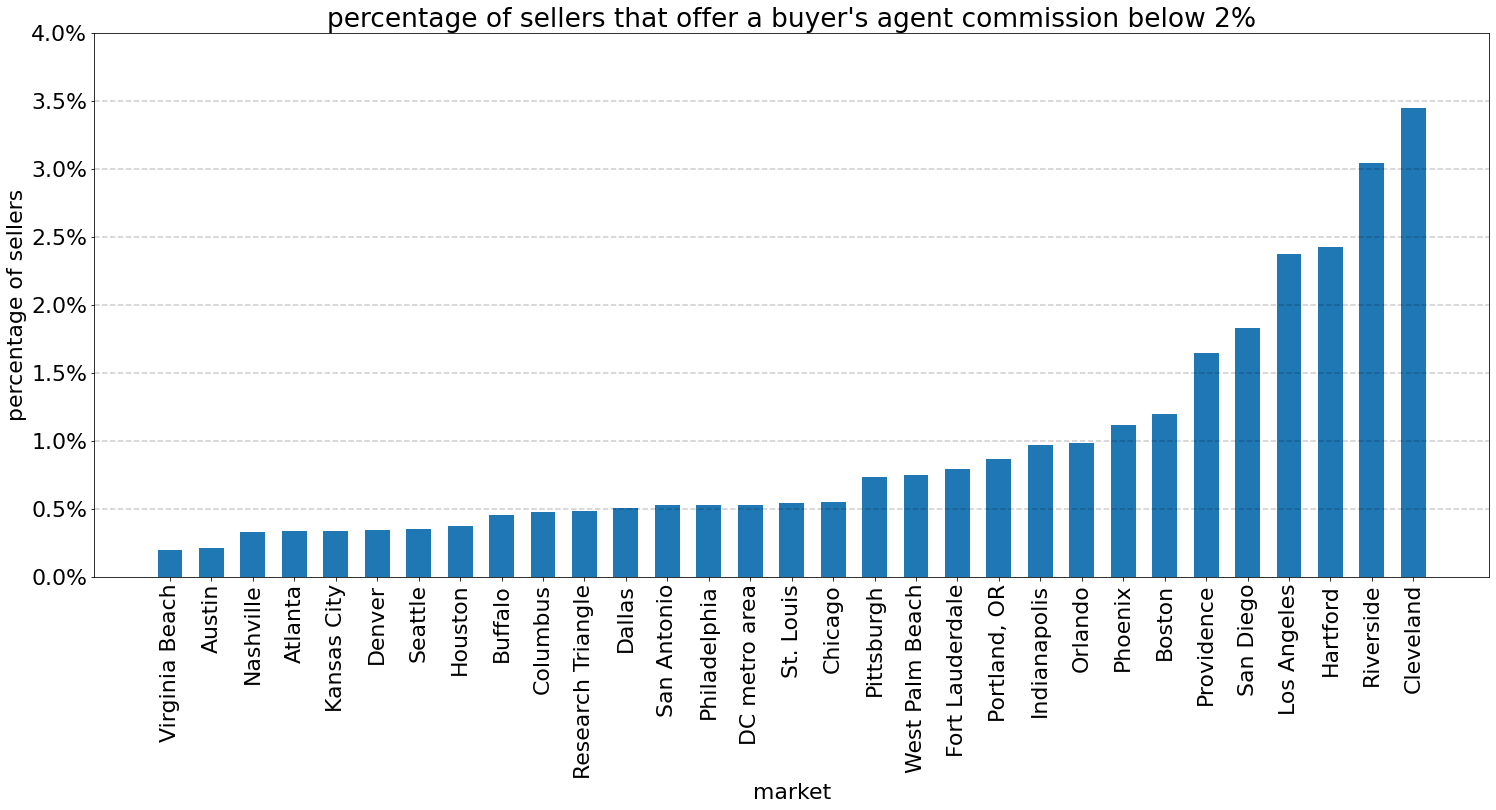

In [47]:
sorted_df = market_area_summary_stats_df_high_response.sort_values('pct_under_2')

plt.figure(figsize=(25, 10))
x_pos = np.arange(len(market_area_summary_stats_df_high_response))
plt.bar(x_pos, list(sorted_df['pct_under_2']), align='center', alpha=1.0, width=width)
plt.xticks(x_pos, list(sorted_df['market_area']), rotation=90)
plt.xlabel('market')
plt.ylabel('percentage of sellers')
for i in np.linspace(0.5, 3.5, 7):
    plt.axhline(y=i, color='k', linestyle='--', alpha=0.2)
plt.title("percentage of sellers that offer a buyer's agent commission below 2%")
plt.ylim((0, np.ceil(max(sorted_df['pct_under_2']))))
plt.gca().set_yticklabels([f'{x/100:.1%}' for x in plt.gca().get_yticks()]) 
plt.show()

## commission distribution by market

In [48]:
def get_distribution_for_market(market_area, state=None, top_rates=5):
    comm_rates = buyer_commission_df_nonnull_f[
        buyer_commission_df_nonnull_f['market_area'] == market_area]['buyside_commission']
    print(len(comm_rates))
    comm_fracs = comm_rates.value_counts() / len(comm_rates)
    top_comm_pcts = 100 * comm_fracs.iloc[:top_rates]
    top_comm_pcts = top_comm_pcts.loc[top_comm_pcts.index >= 2]
    top_comm_pcts.sort_index(inplace=True)
    top_comm_rates = list(top_comm_pcts.index)
    below_2_pct = 100 * (comm_rates < 2).sum() / len(comm_rates)
    top_comm_pcts_lst = top_comm_pcts.tolist()
    all_pcts = [below_2_pct] + top_comm_pcts_lst
    remaining_pct = 100 - np.sum(all_pcts)
    print('remaining percentage', remaining_pct)

    plt.figure(figsize=(20, 10))
    x_locs = np.arange(len(top_comm_rates) + 1)
    bar_plot = plt.bar(x_locs, all_pcts, width=0.4)
    plt.xticks(x_locs, ['Below 2'] + top_comm_rates, fontsize=20)
    plt.xlabel("buyer's agent commission rate")
    plt.ylabel('percent of listings')
    plt.ylim((0, 100))
    plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
    market = market_area
    if state:
        market += f', {state}'
    plt.title(market)
    
    for idx, rect in enumerate(bar_plot):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + 1,
                 f'{round(all_pcts[idx], 1)}%',
                 ha='center', va='bottom', rotation=0, fontsize=16)
    plt.show()

3040
remaining percentage 1.4802631578947256


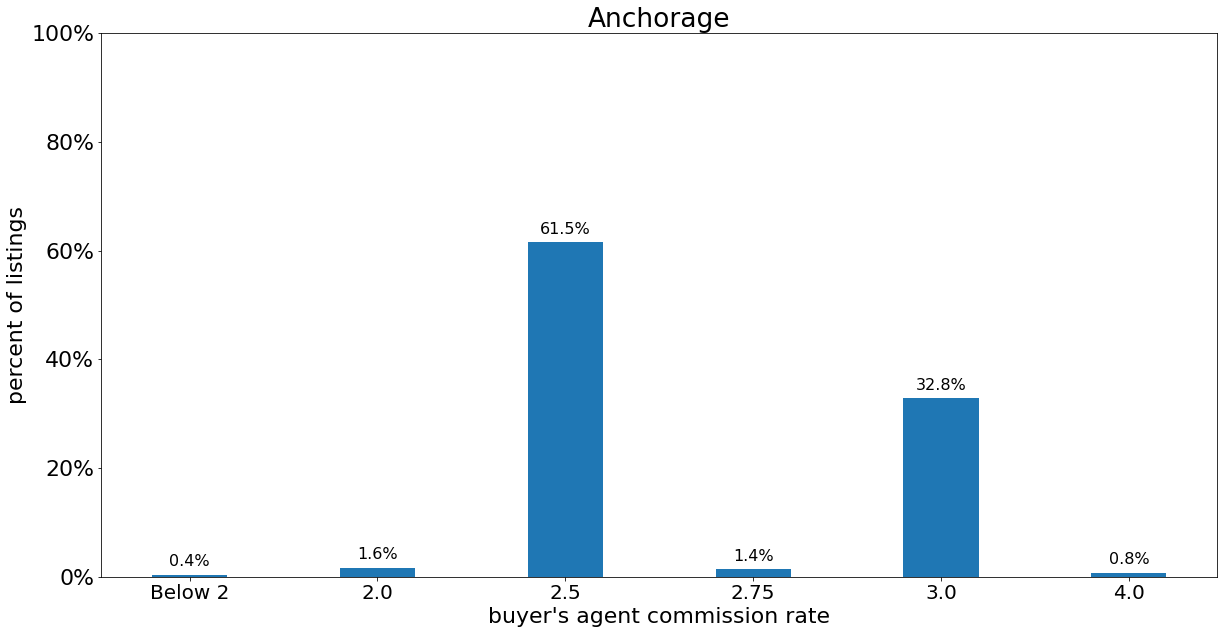

52600
remaining percentage 0.7756653992395428


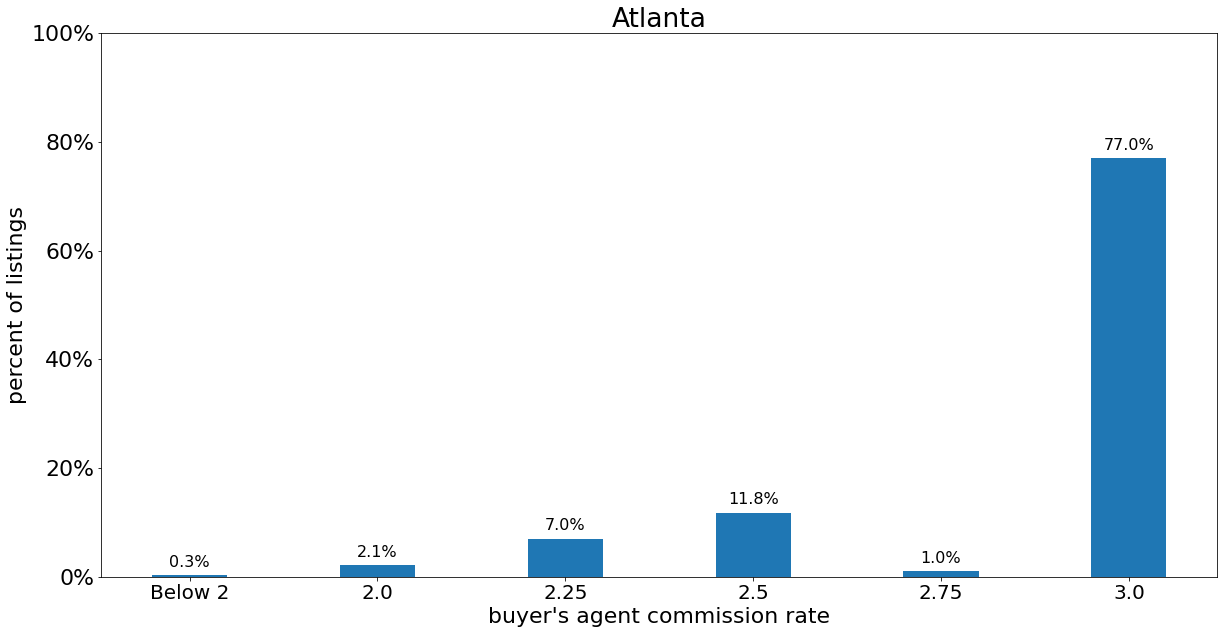

26523
remaining percentage 0.18097500282773638


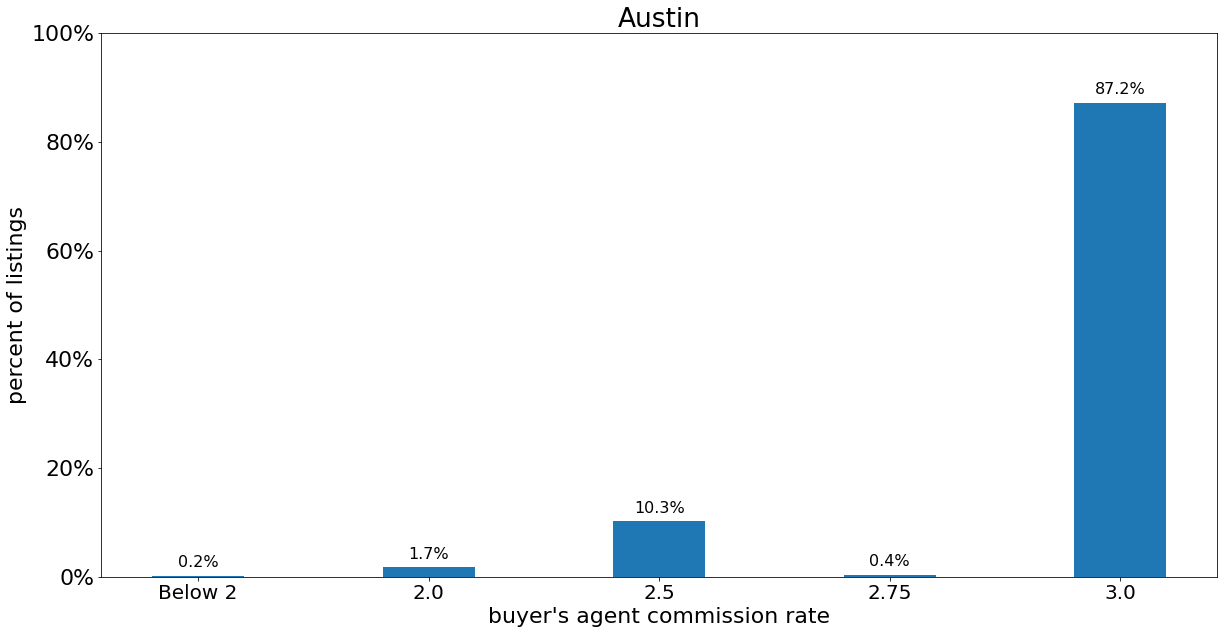

647
remaining percentage 0.9273570324574933


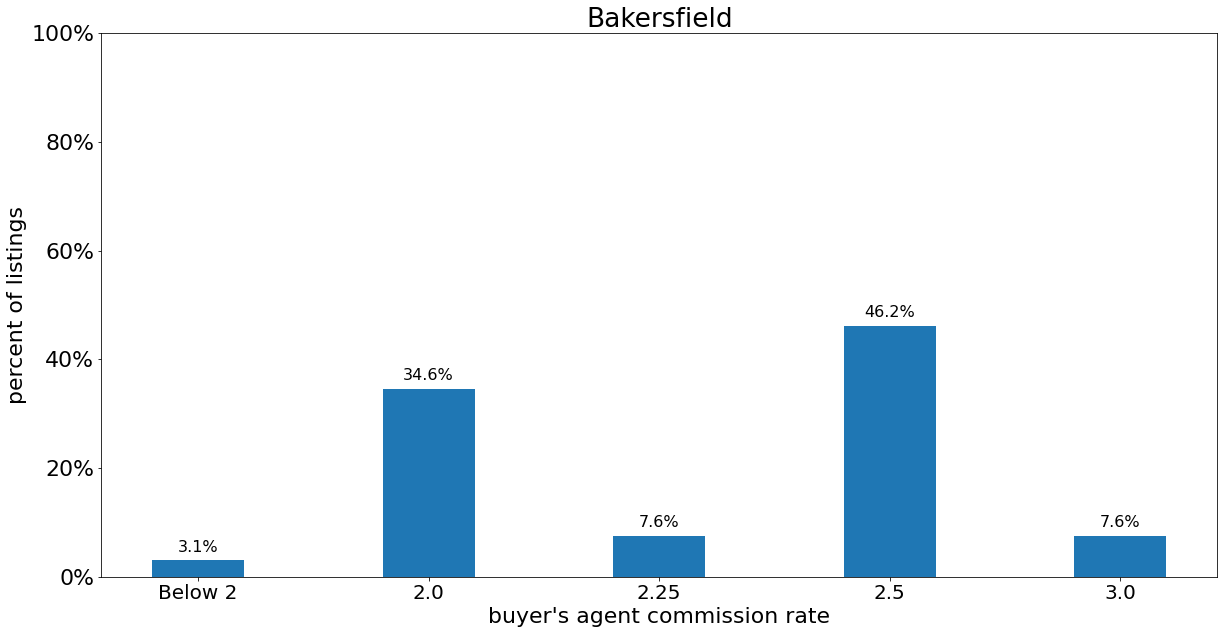

1370
remaining percentage 0.4379562043795602


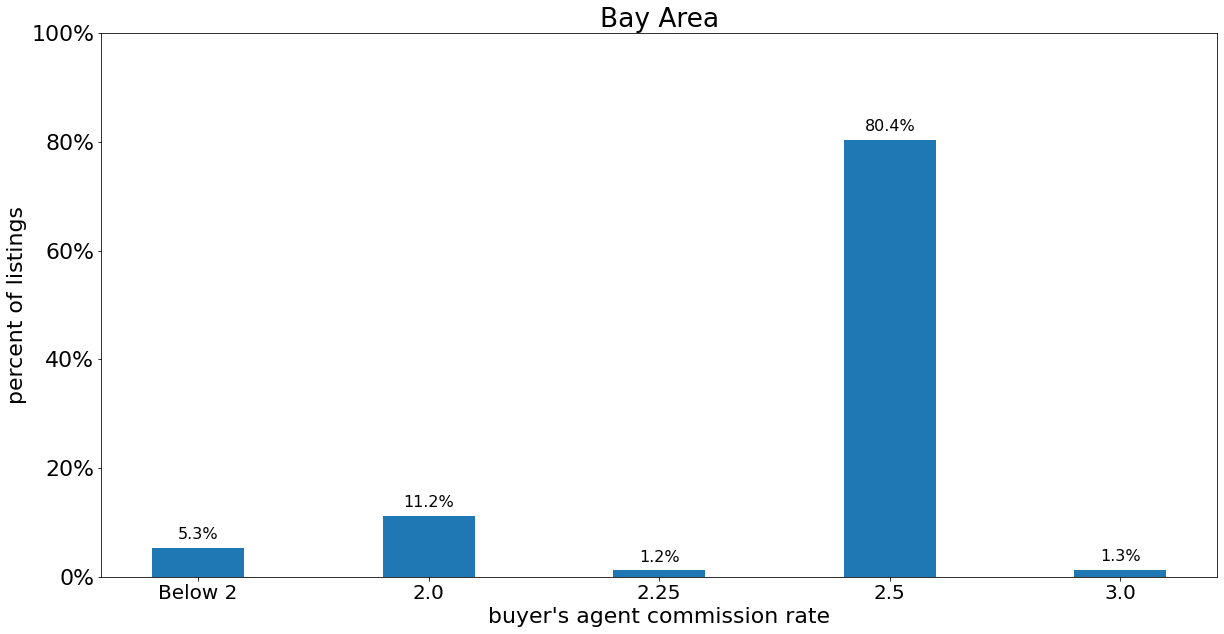

1298
remaining percentage 0.8474576271186436


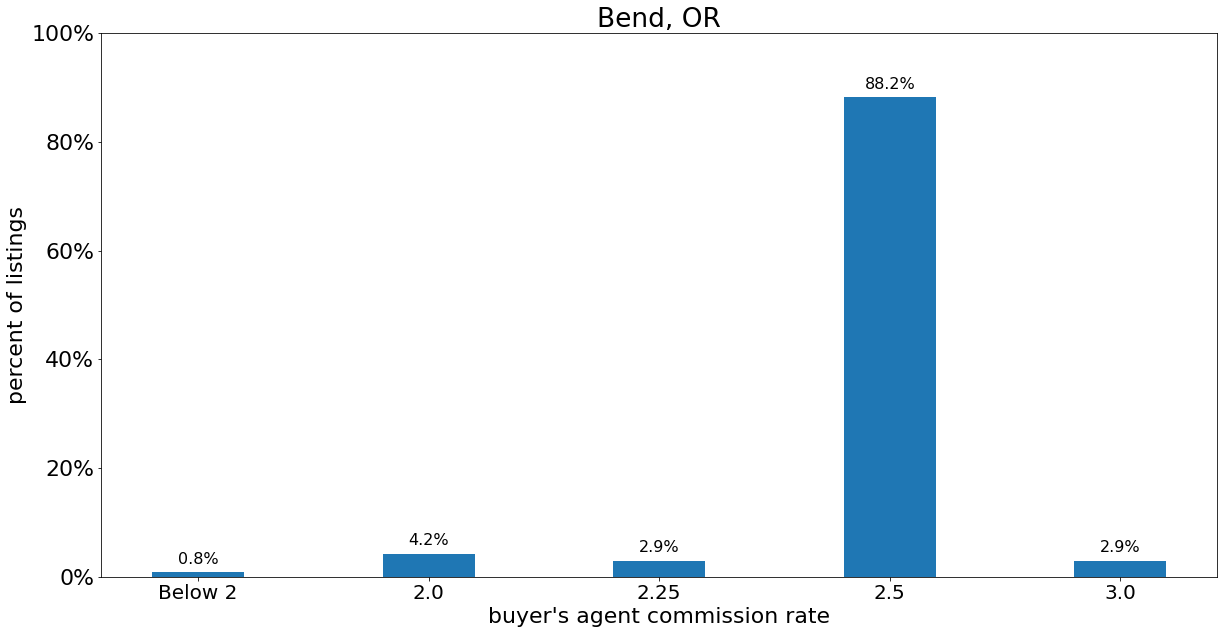

45618
remaining percentage 0.2915515805164546


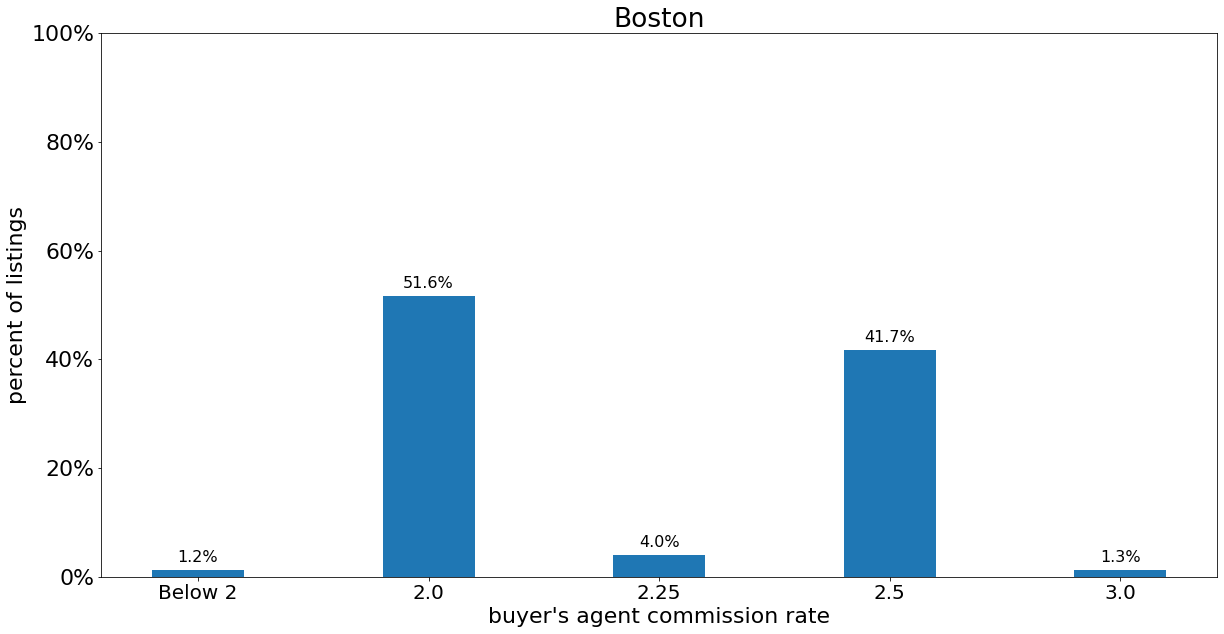

5146
remaining percentage 1.5157403808783414


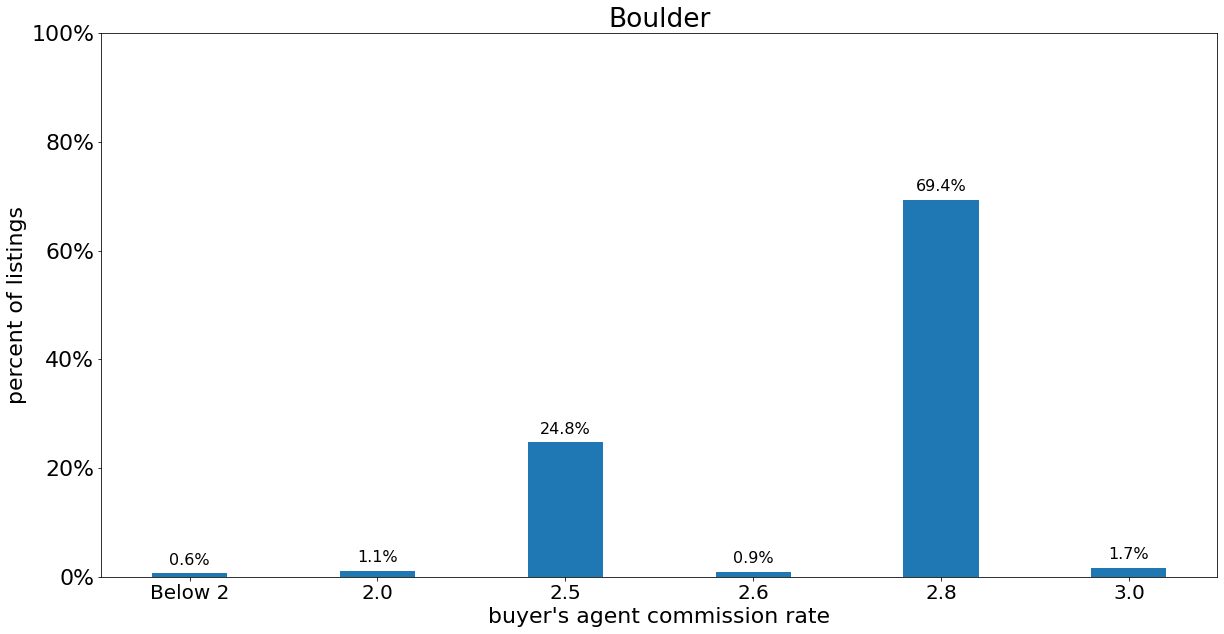

5273
remaining percentage 2.5033187938554846


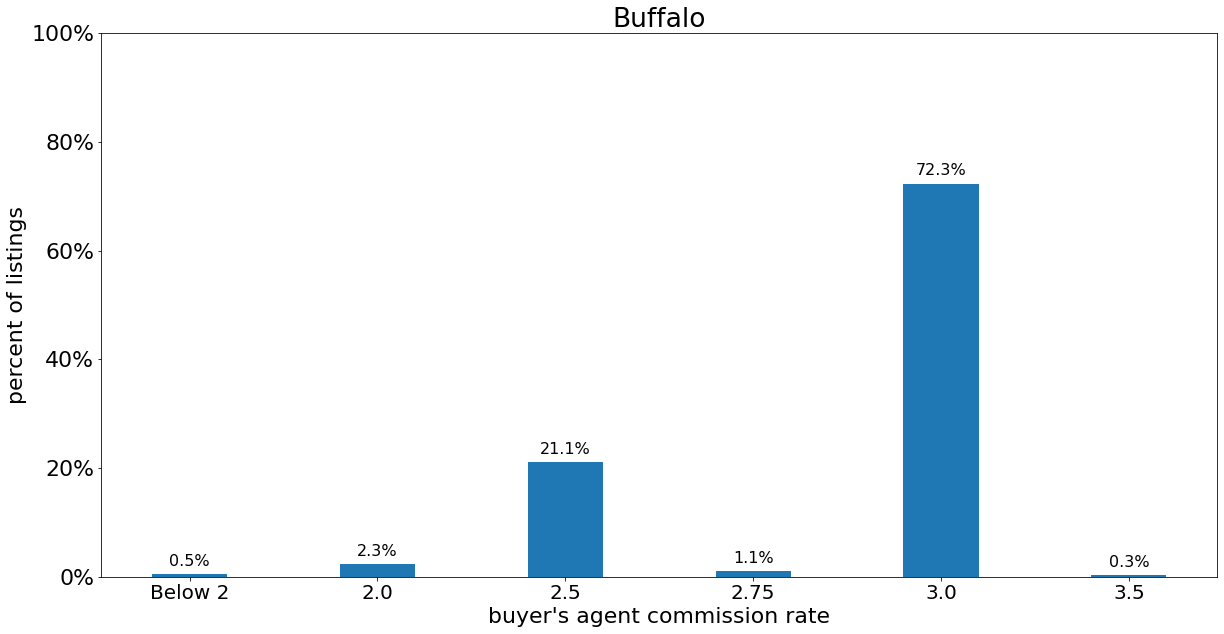

23711
remaining percentage 1.6152840453797808


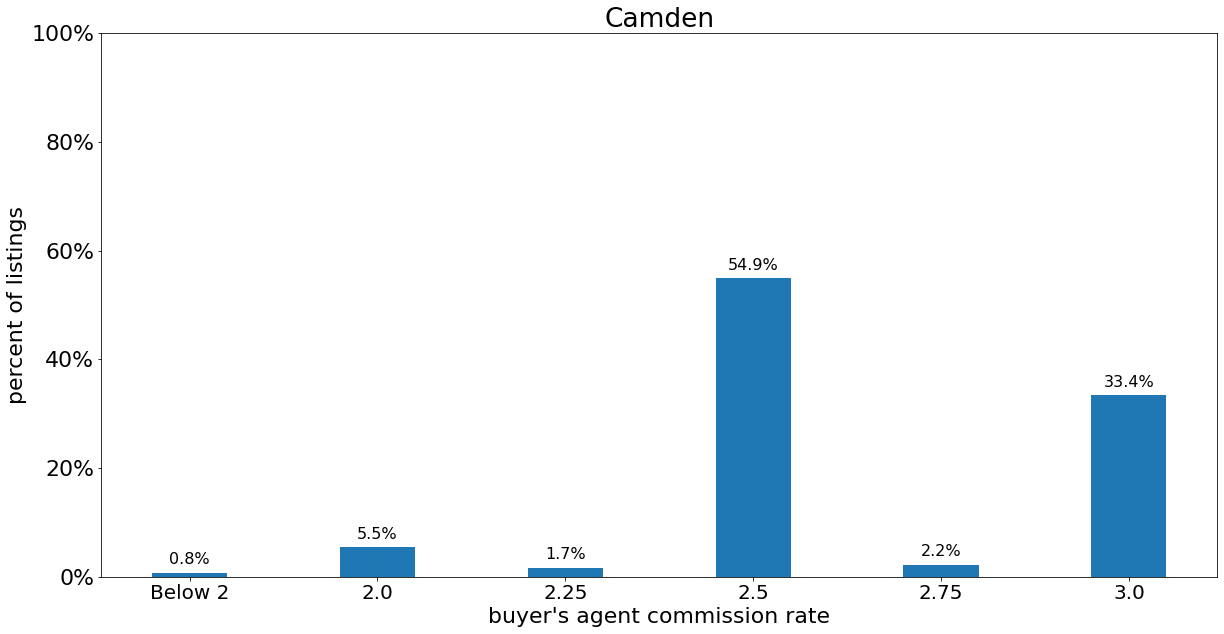

111
remaining percentage 0.9009009009009077


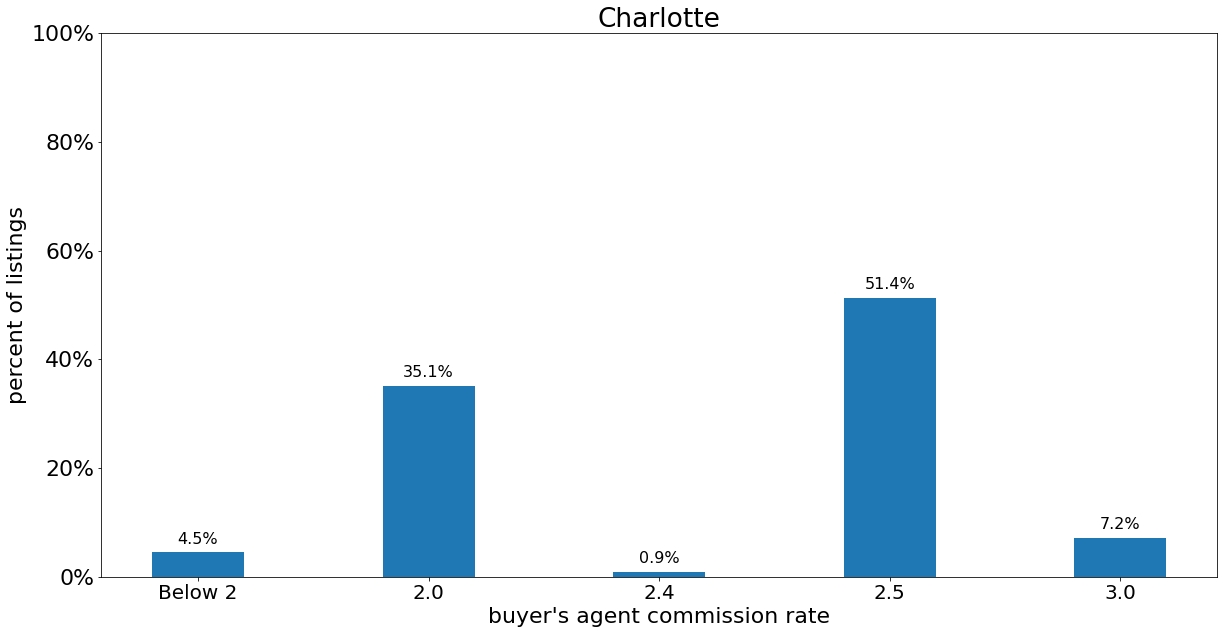

89168
remaining percentage 4.7999282253723266


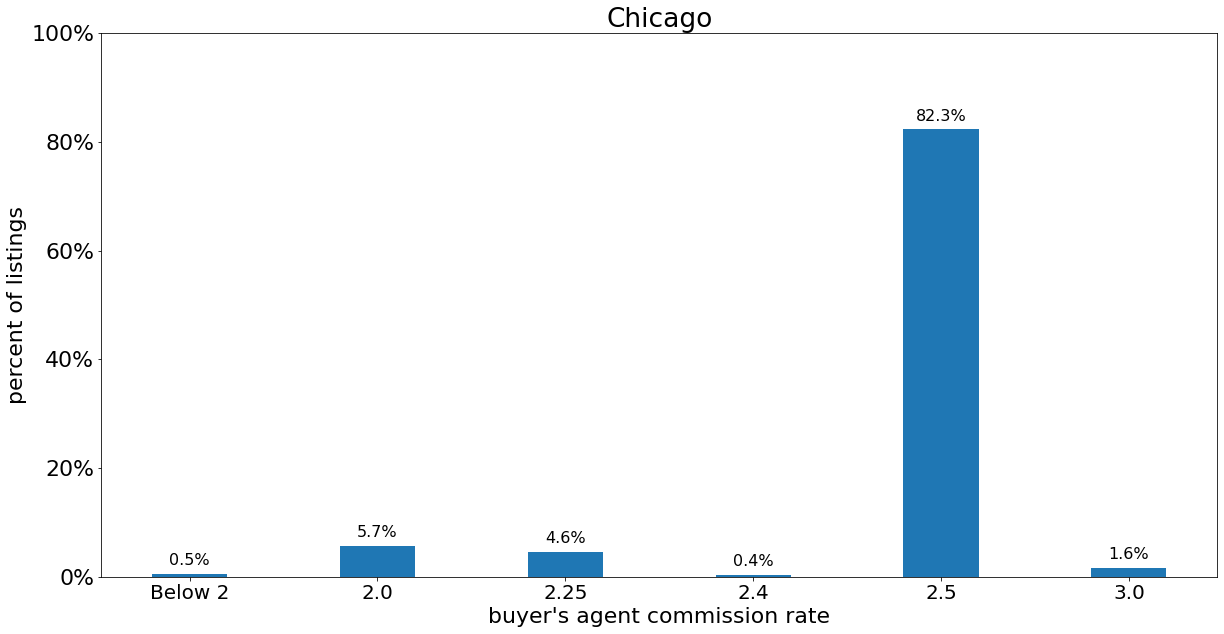

6496
remaining percentage 7.1890394088670035


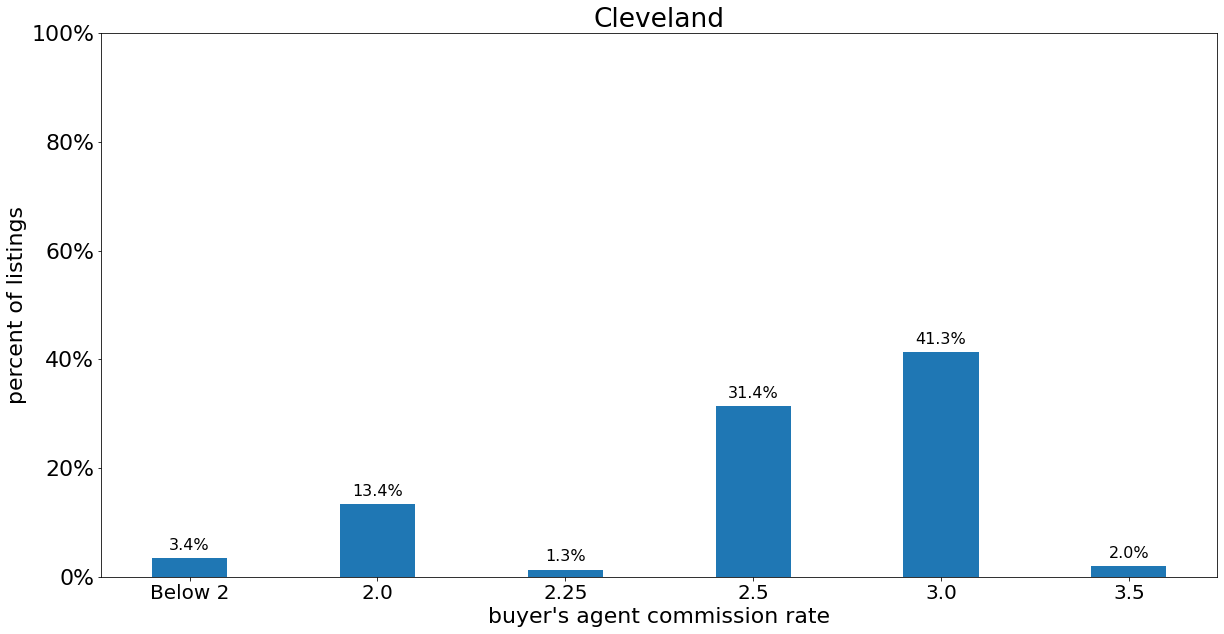

3379
remaining percentage 1.7460787215152465


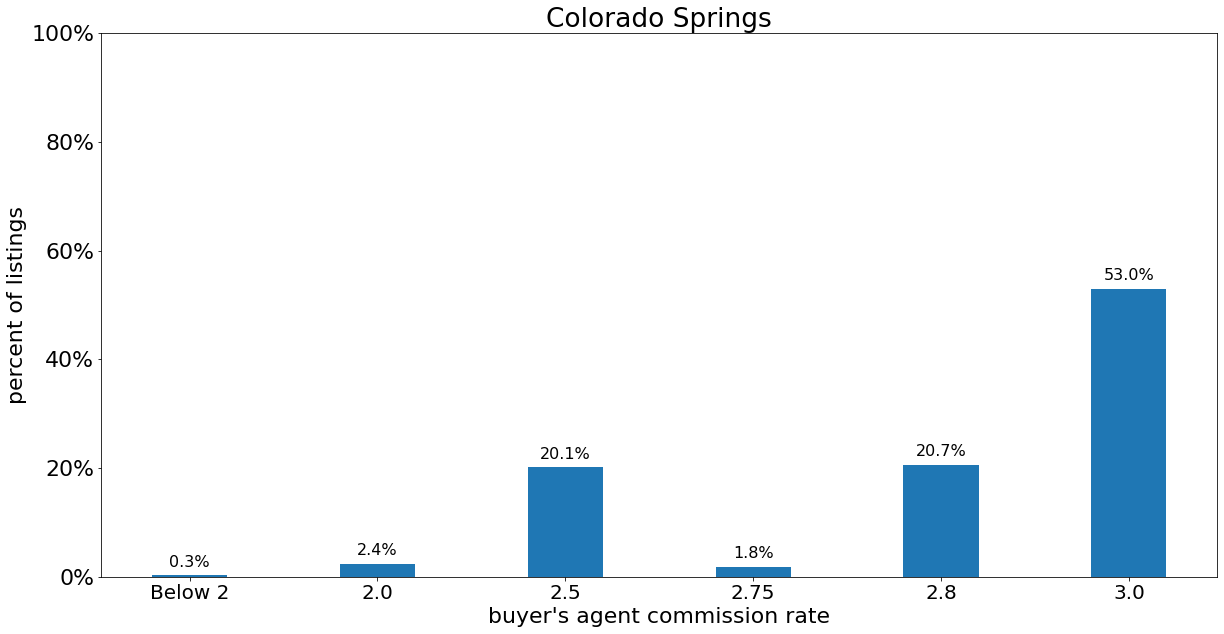

14050
remaining percentage 0.654804270462634


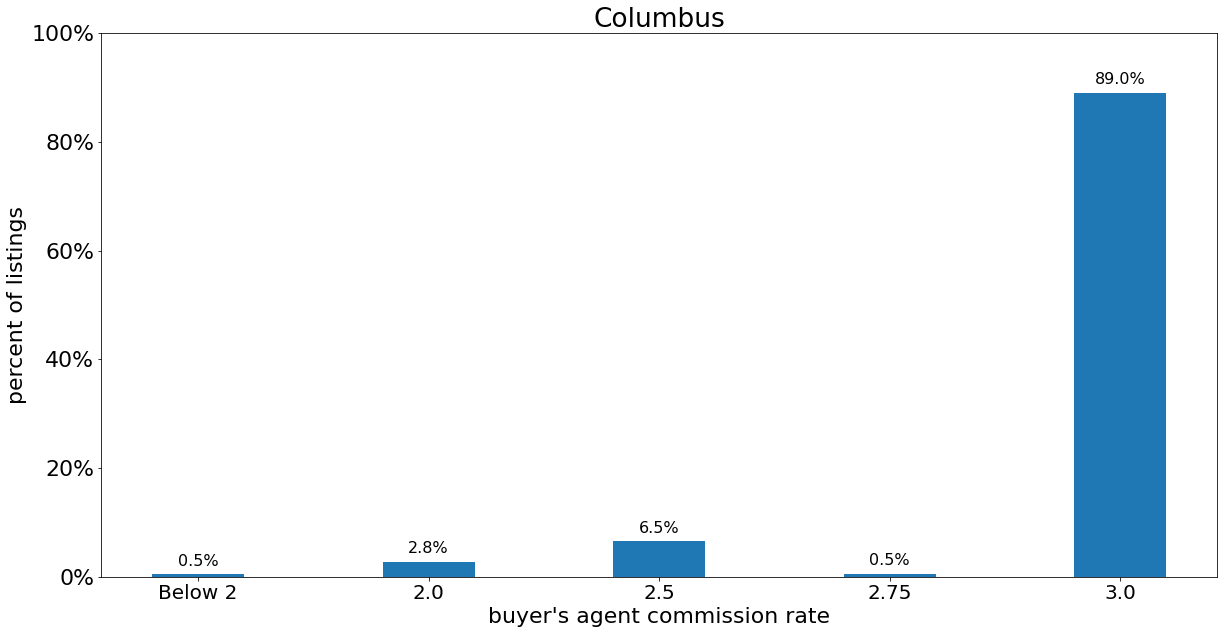

69701
remaining percentage 0.3041563248733894


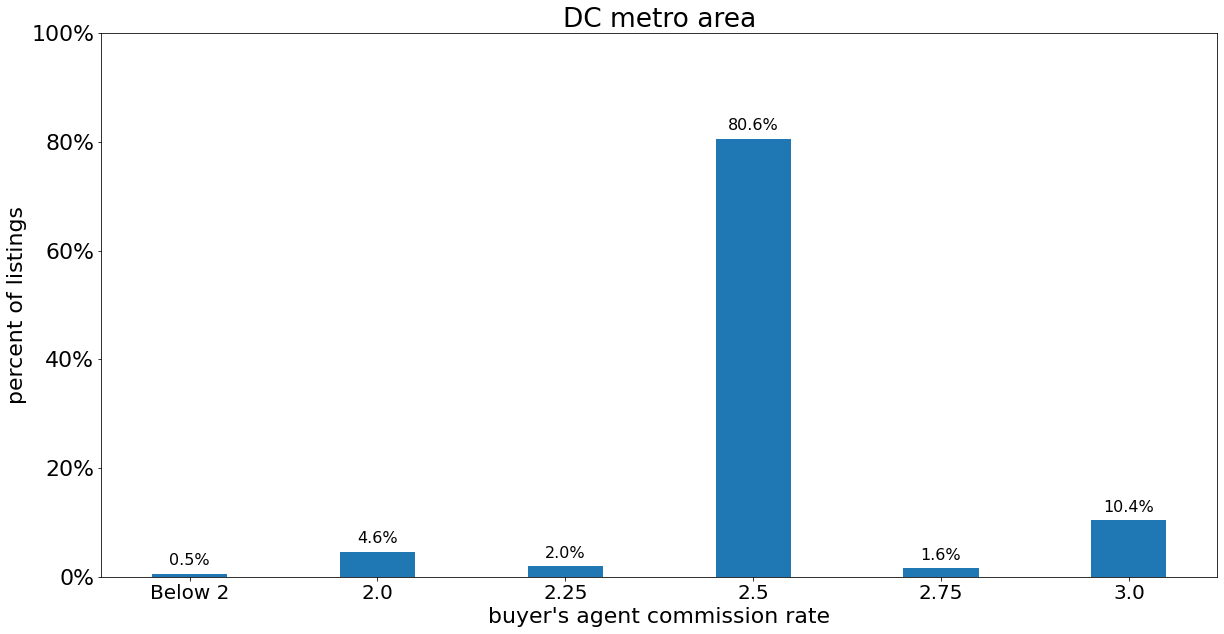

41931
remaining percentage 0.3481910758150235


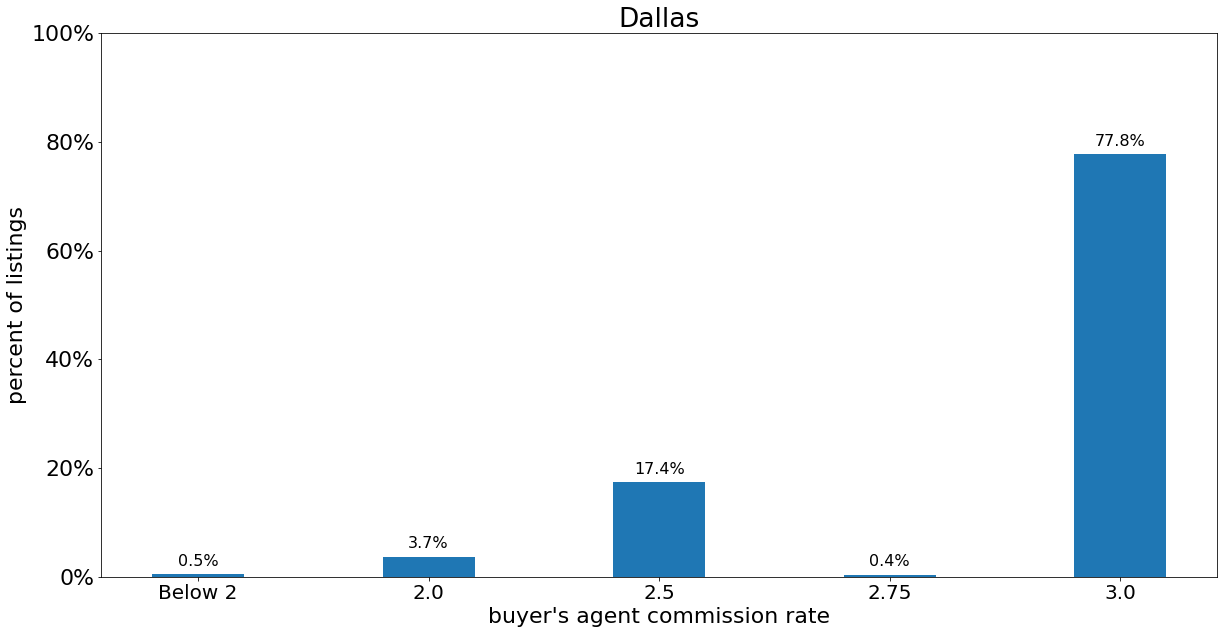

36225
remaining percentage 1.1511387163561153


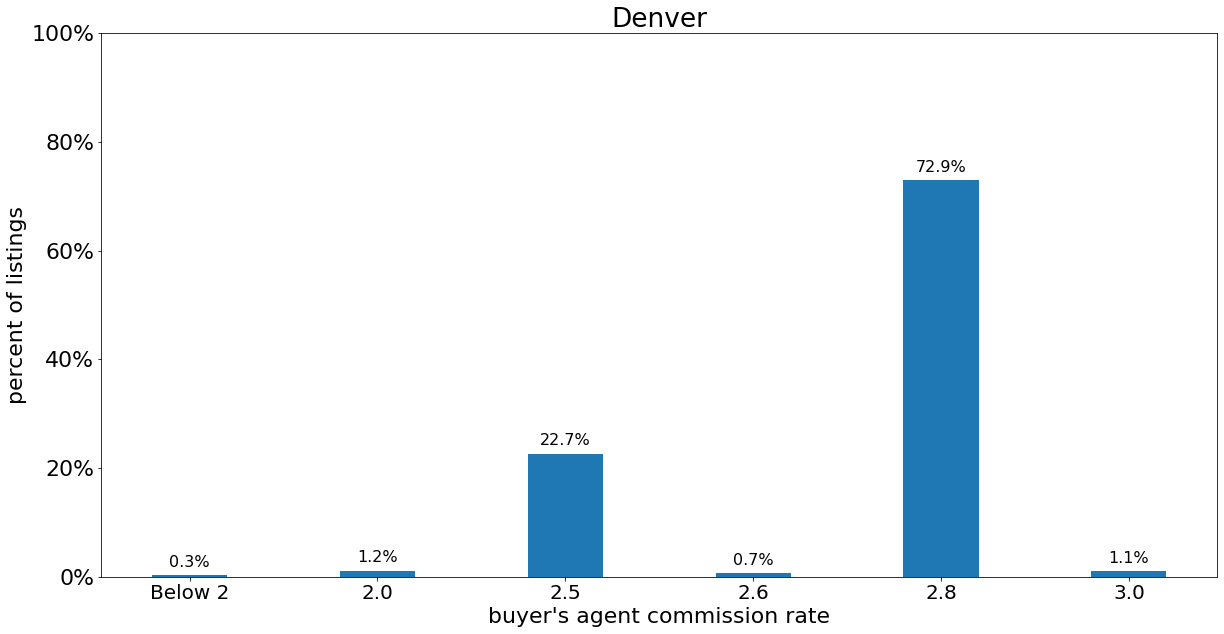

2126
remaining percentage 0.3292568203198414


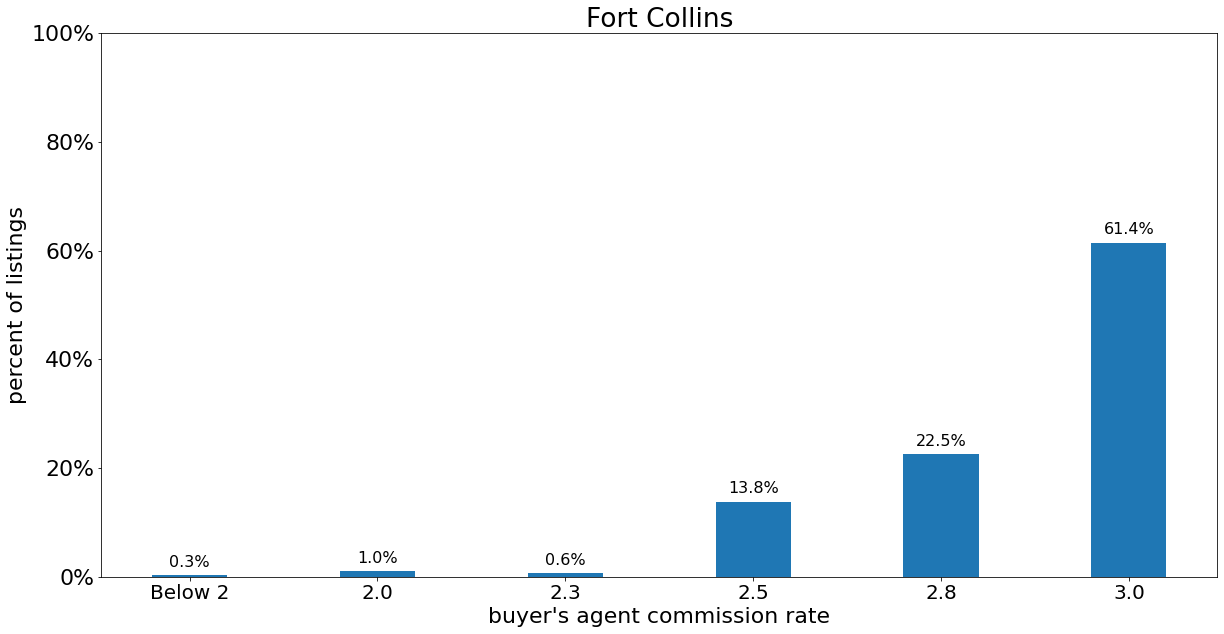

22938
remaining percentage 1.028860406312674


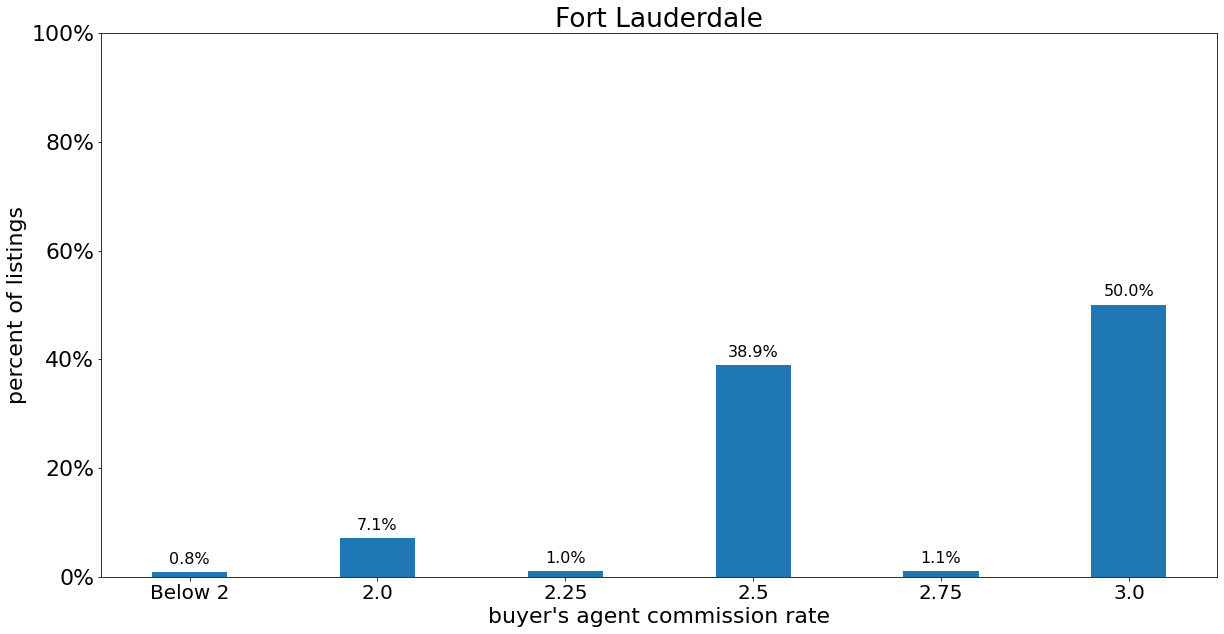

276
remaining percentage 1.8115942028985472


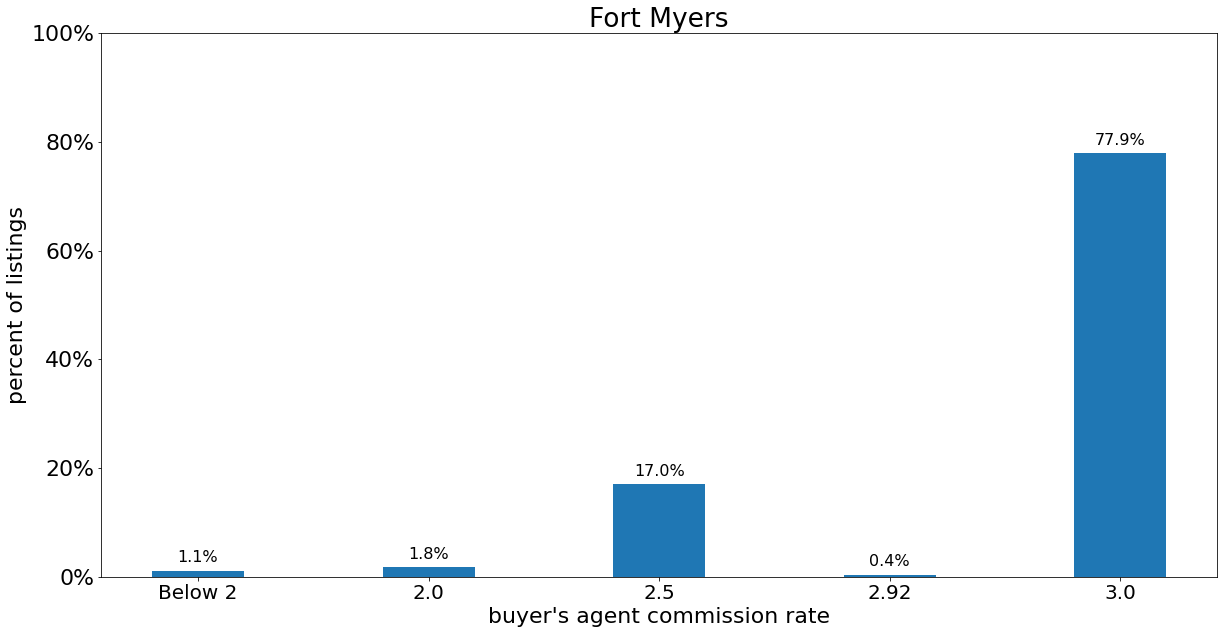

8209
remaining percentage 1.2059934218540604


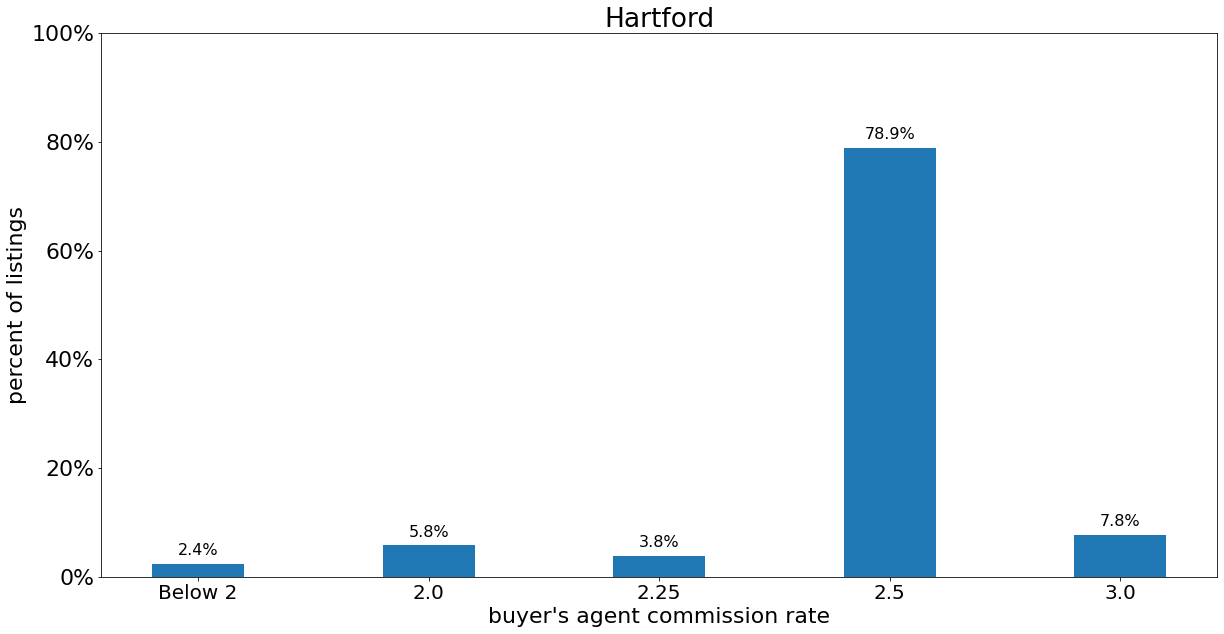

68034
remaining percentage 0.33071699444396074


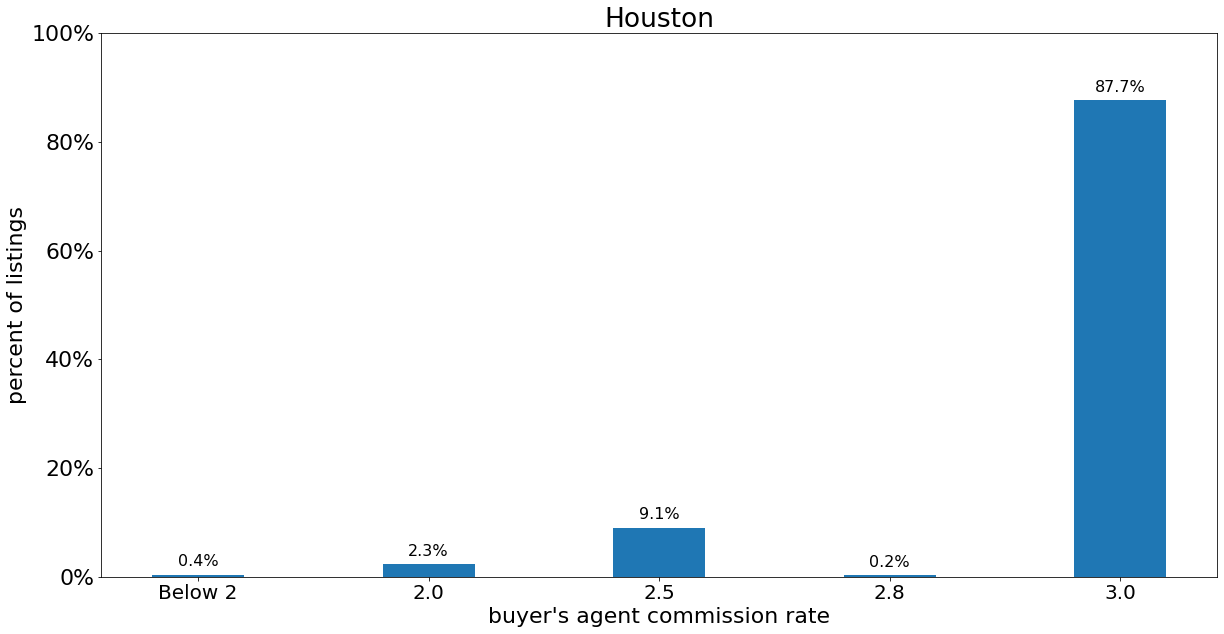

15620
remaining percentage 5.7234314980793926


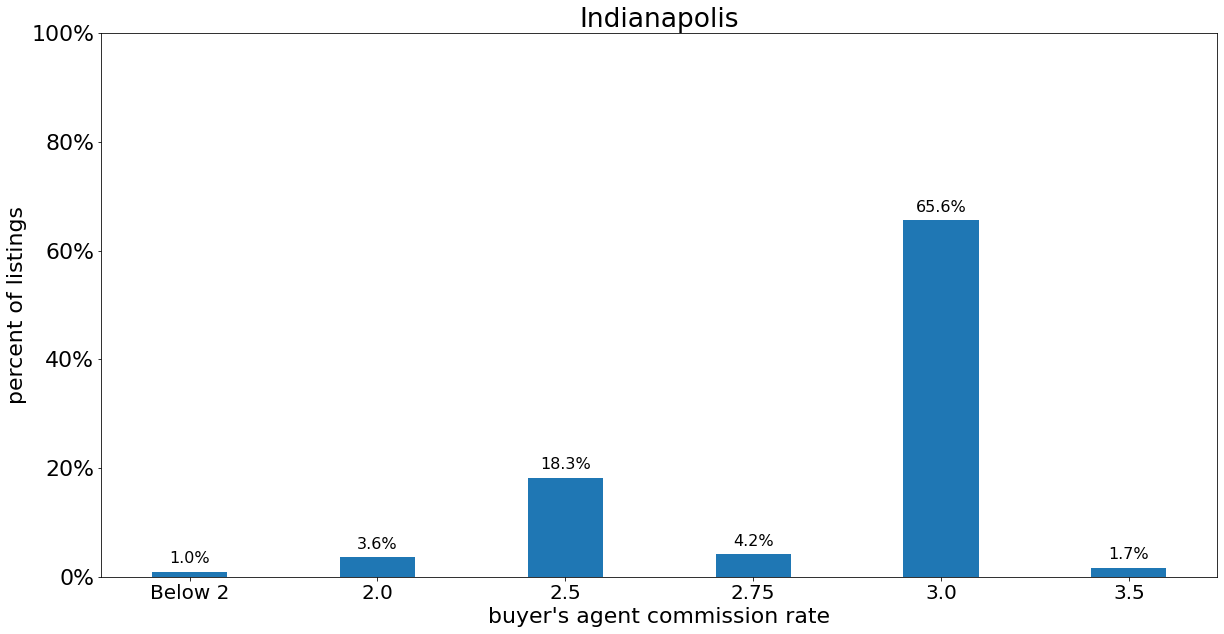

247
remaining percentage 1.214574898785429


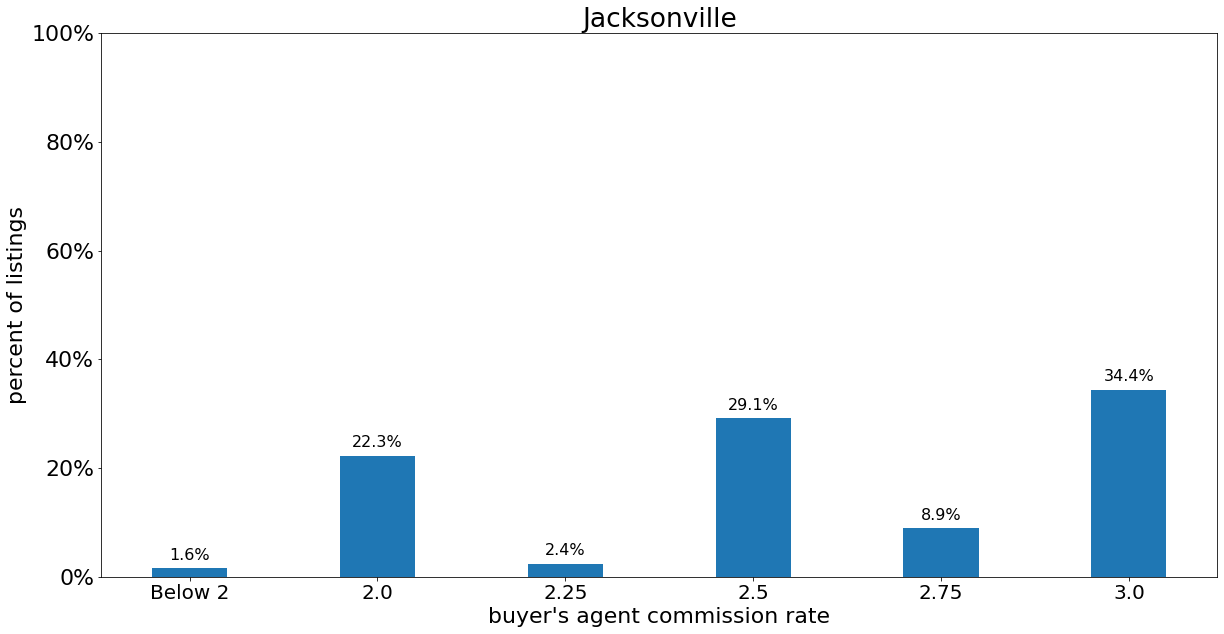

21080
remaining percentage 0.4933586337760971


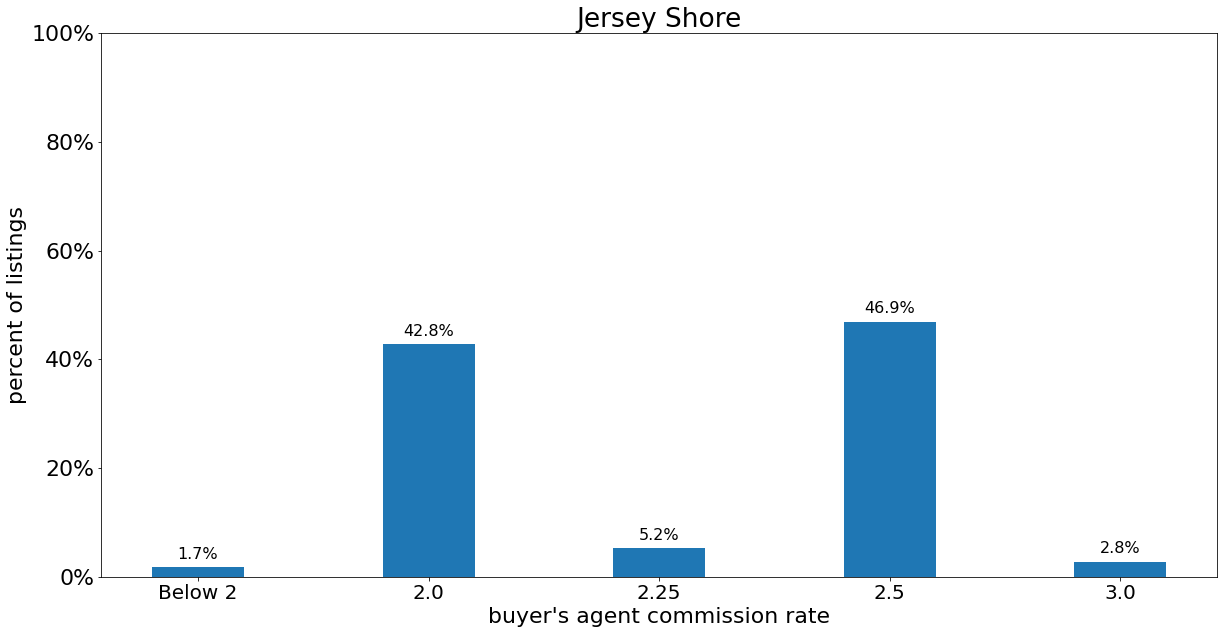

14201
remaining percentage 0.9928878248010733


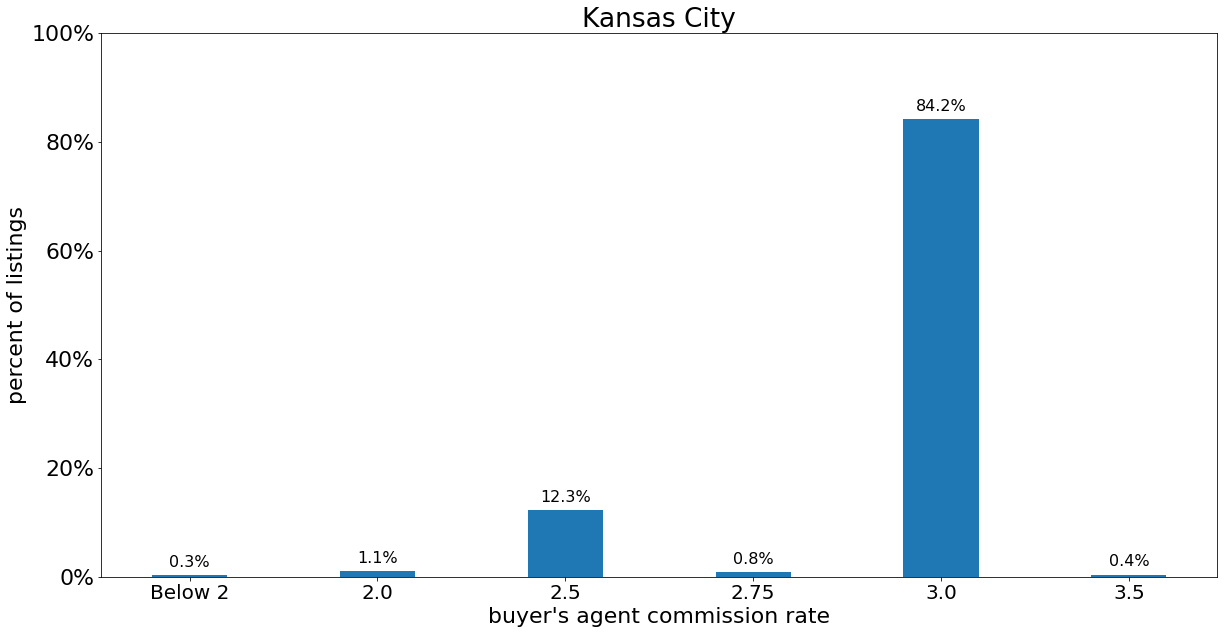

247
remaining percentage 0.0


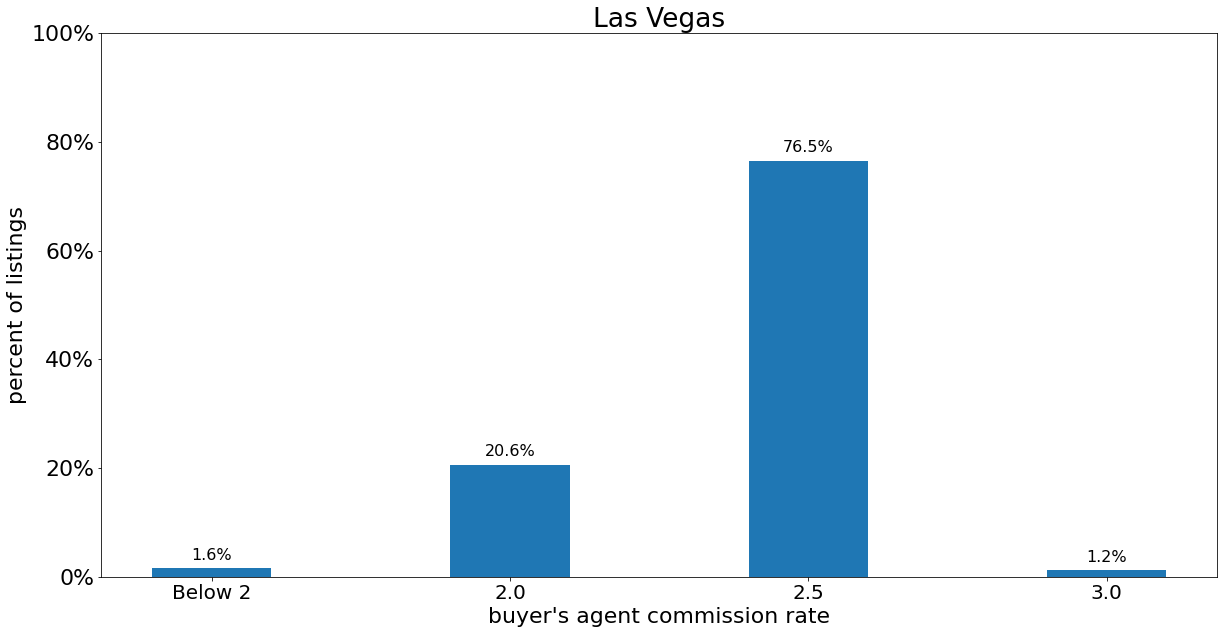

75105
remaining percentage 0.781572465215362


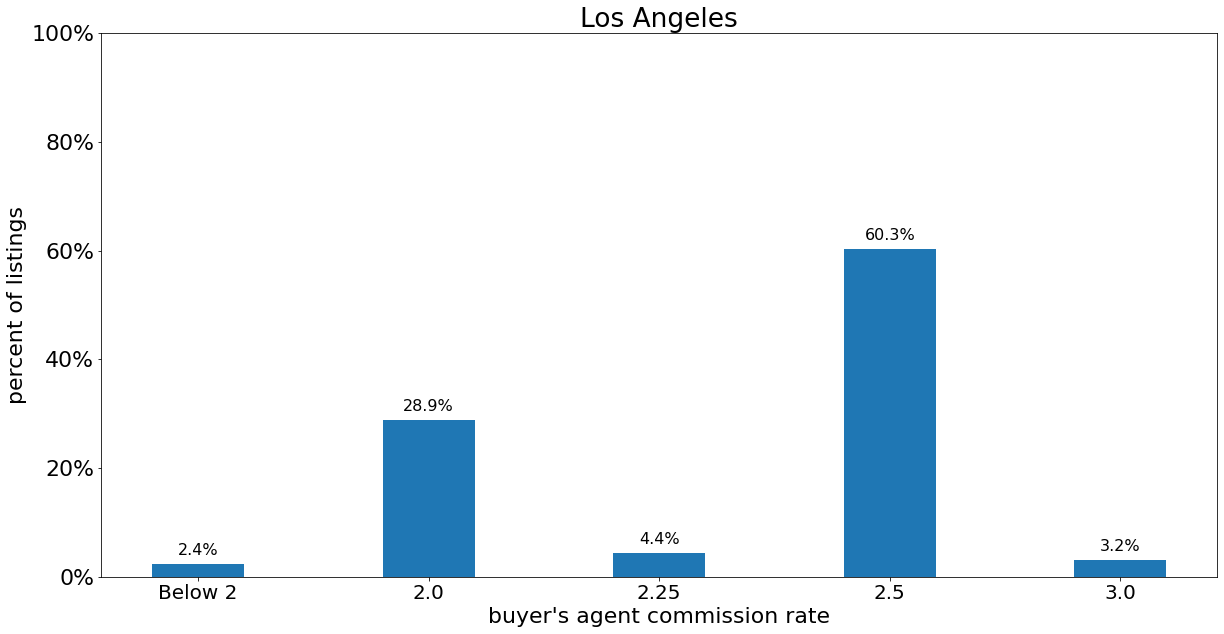

296
remaining percentage 1.3513513513513544


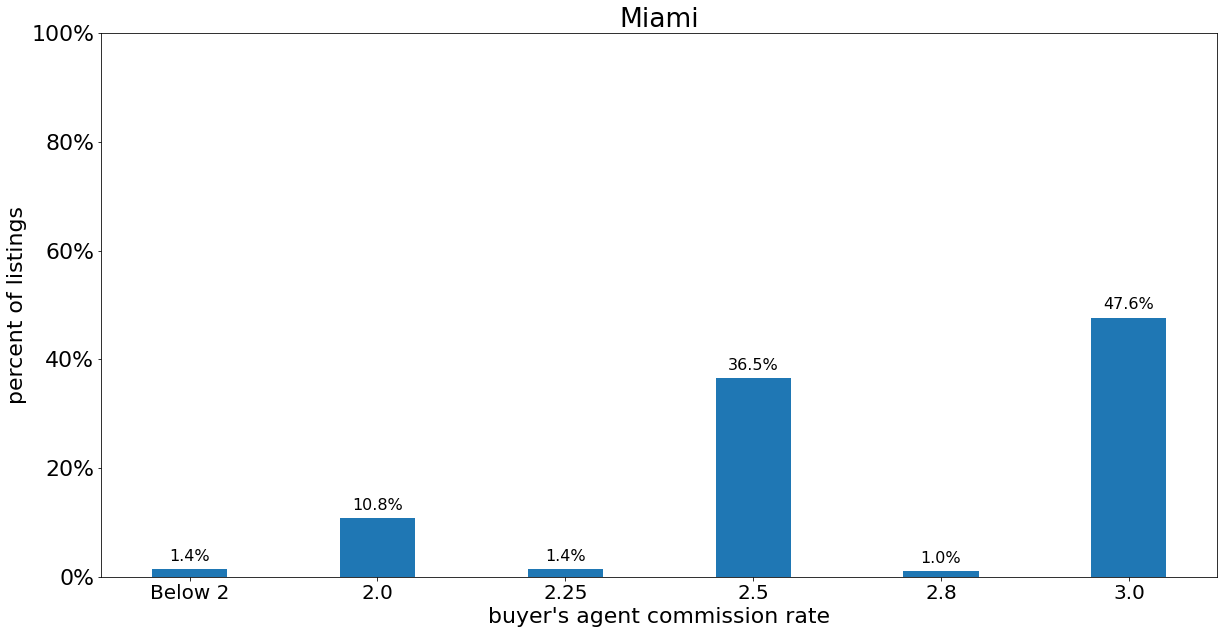

229
remaining percentage 1.4210854715202004e-14


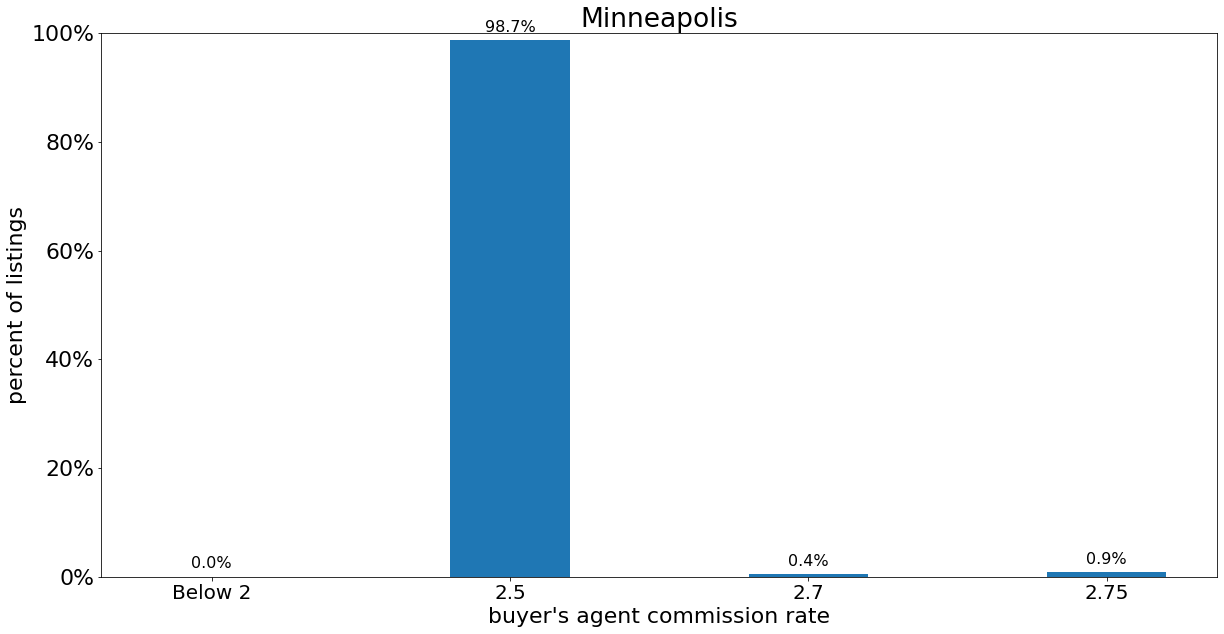

330
remaining percentage 1.5151515151515014


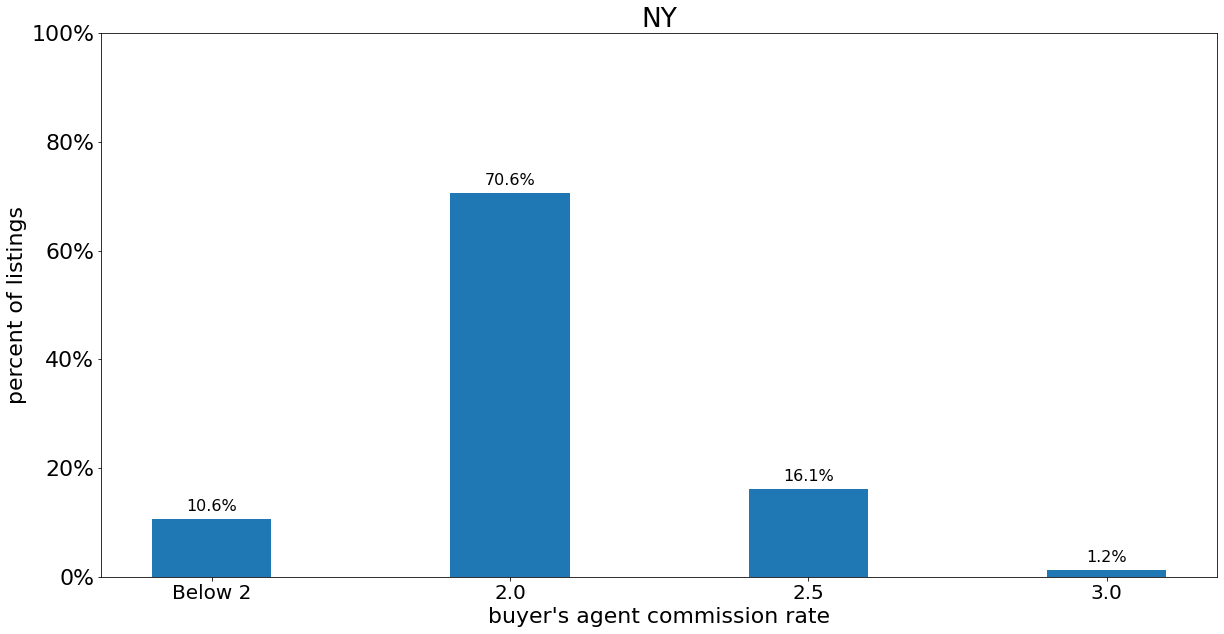

15300
remaining percentage 0.4117647058823479


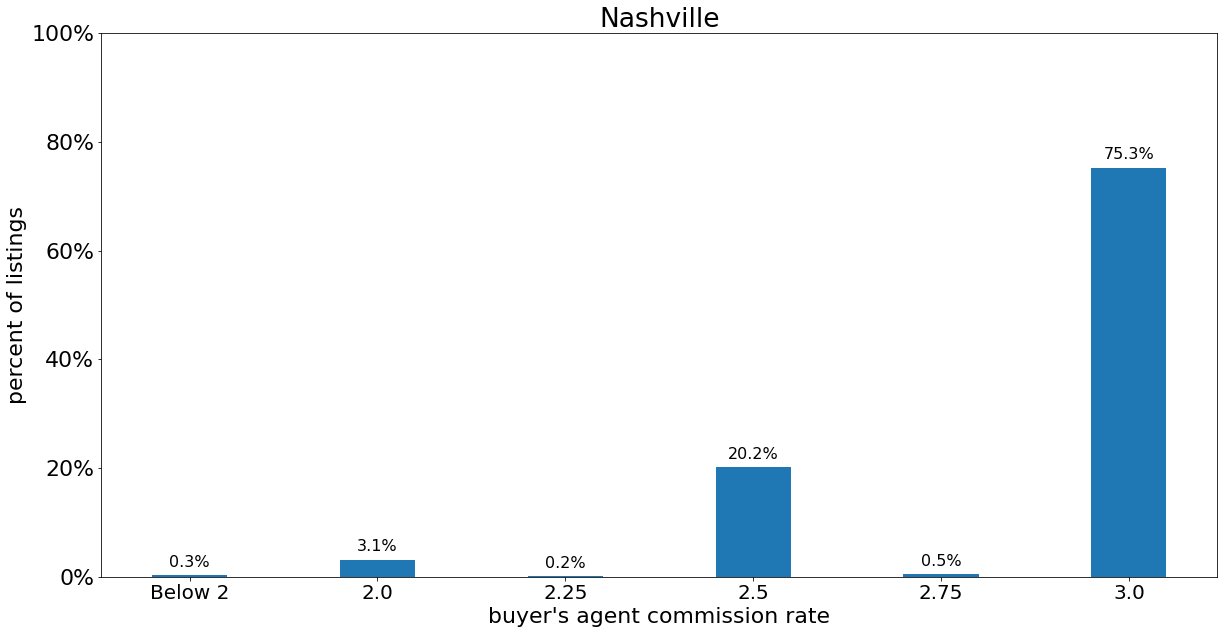

5039
remaining percentage 0.912879539591188


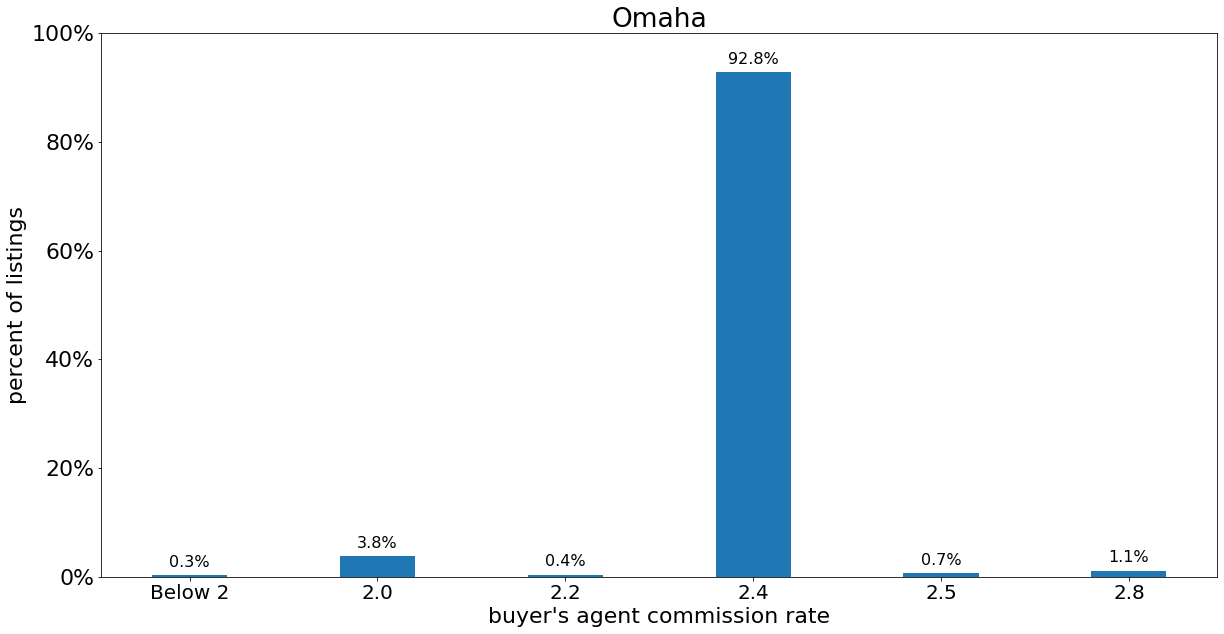

25670
remaining percentage 1.0907674328009307


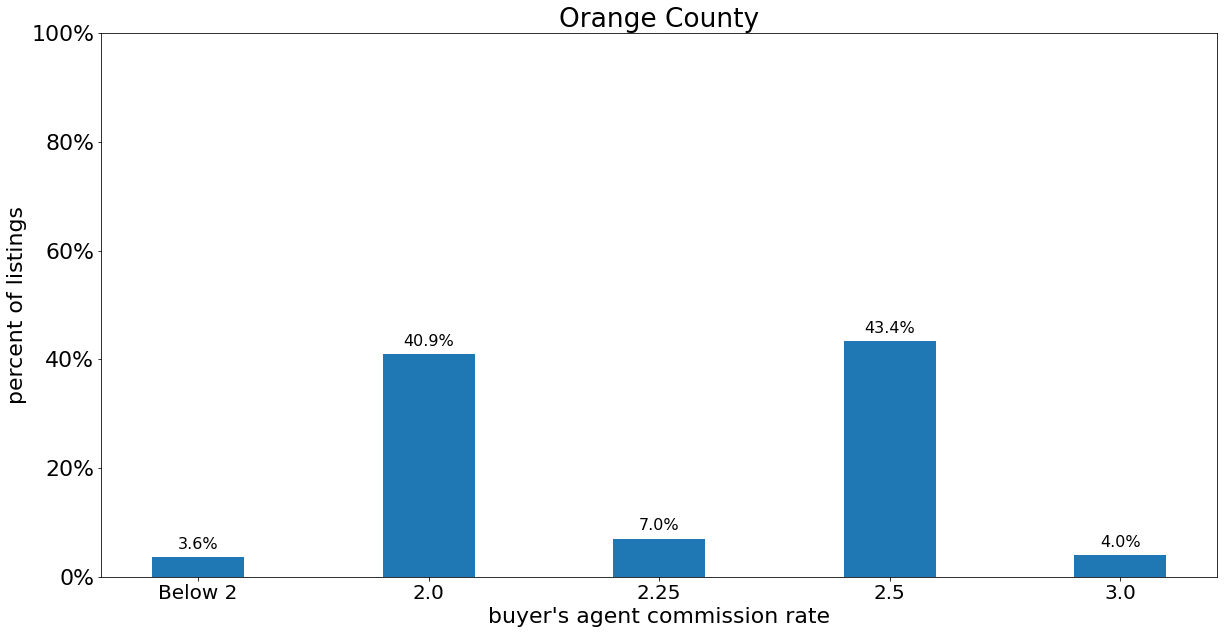

11092
remaining percentage 2.5784349080418423


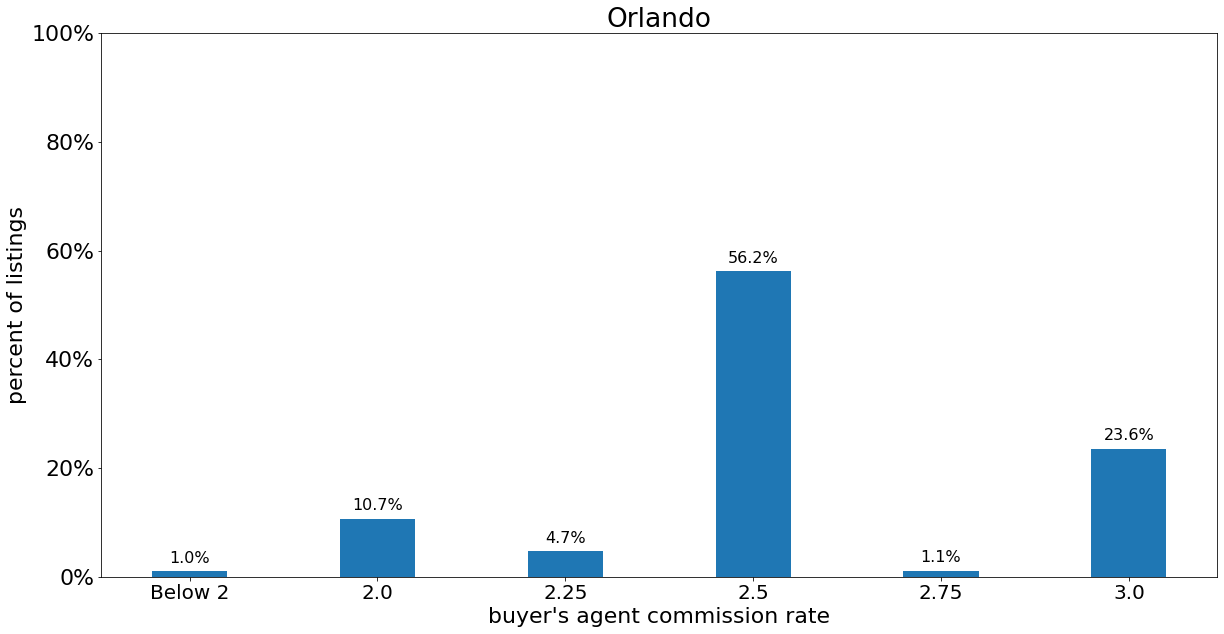

58770
remaining percentage 0.9188361408882173


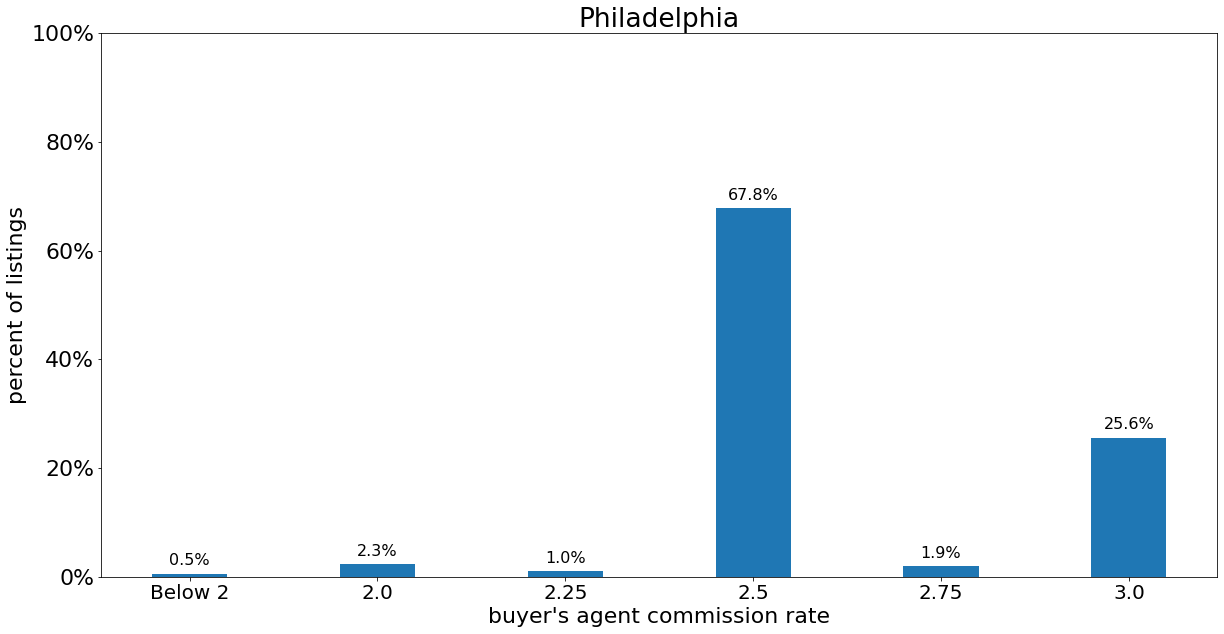

19605
remaining percentage 0.6579954093343616


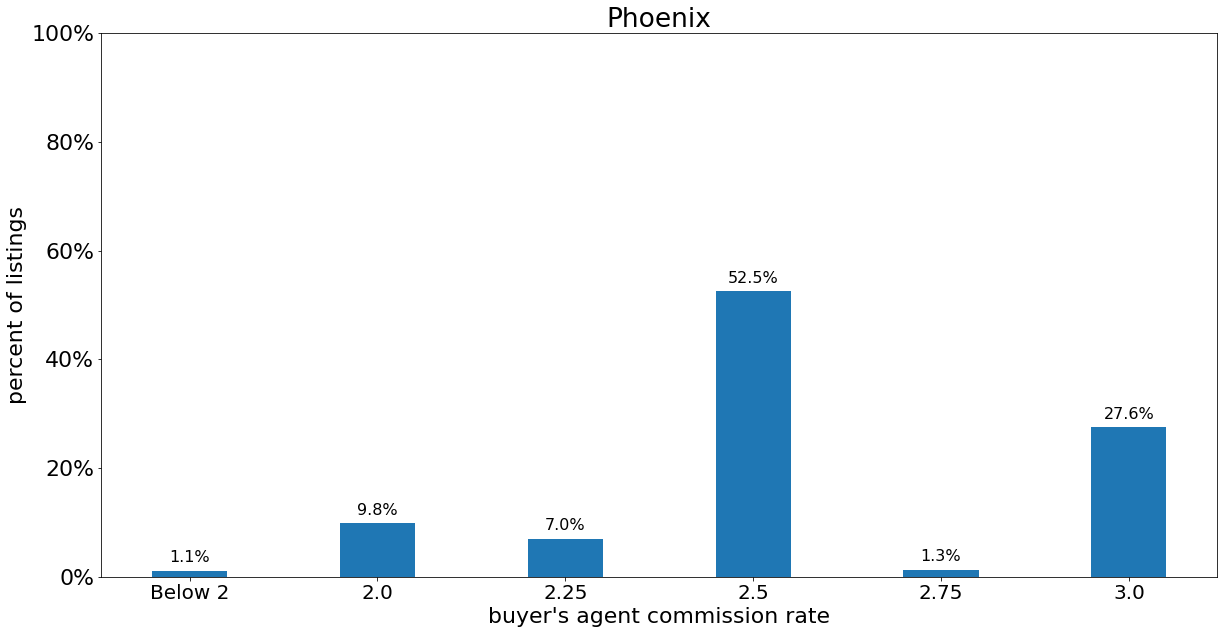

13475
remaining percentage 6.166975881261607


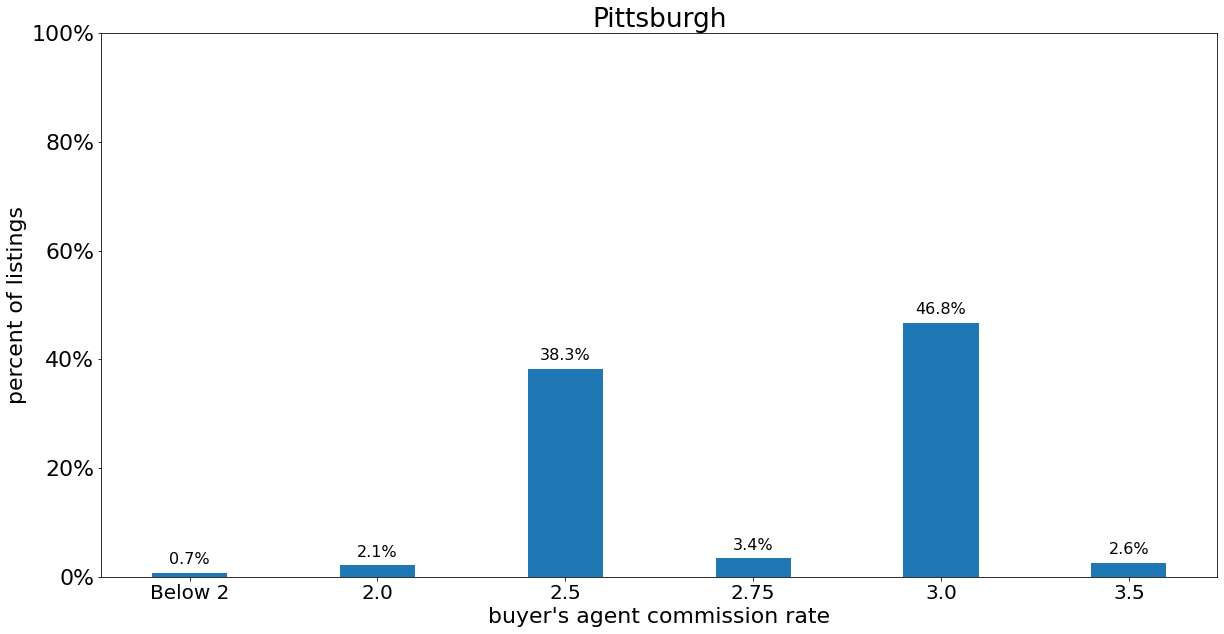

24906
remaining percentage 1.3691479964667082


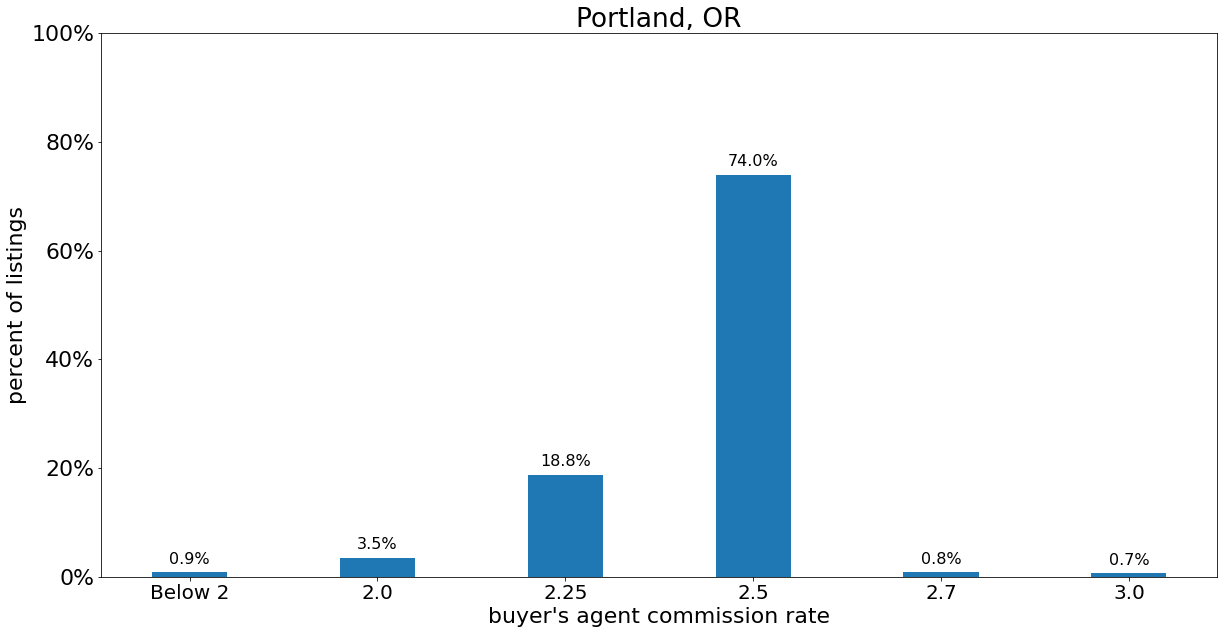

2789
remaining percentage 1.0756543564001504


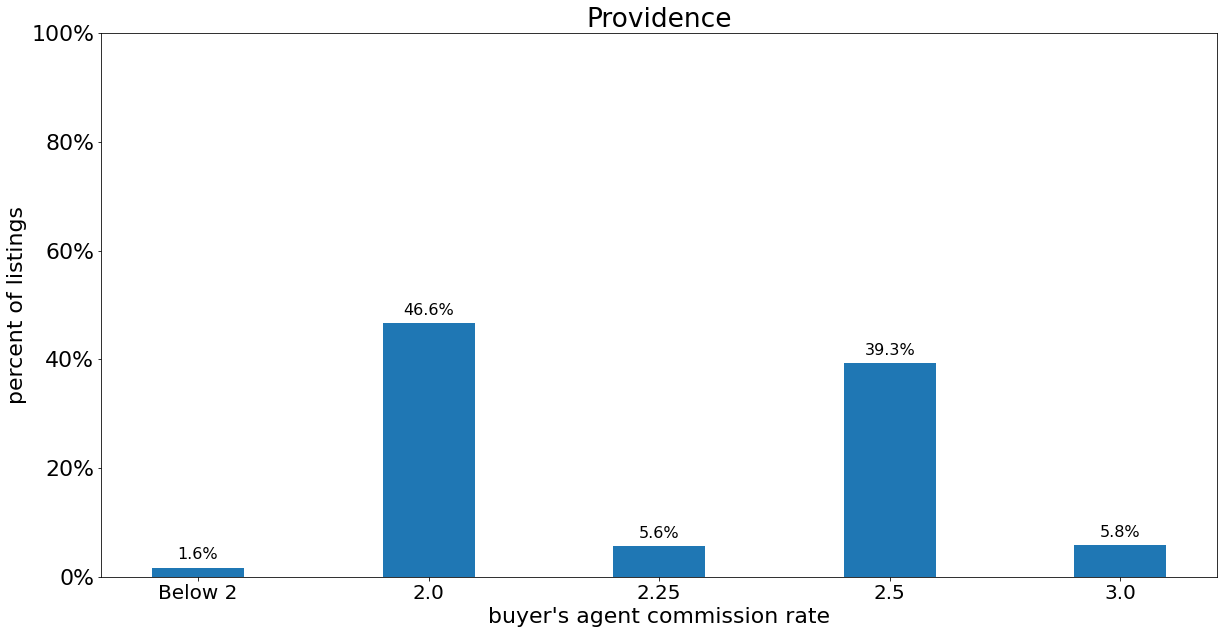

29
remaining percentage 0.0


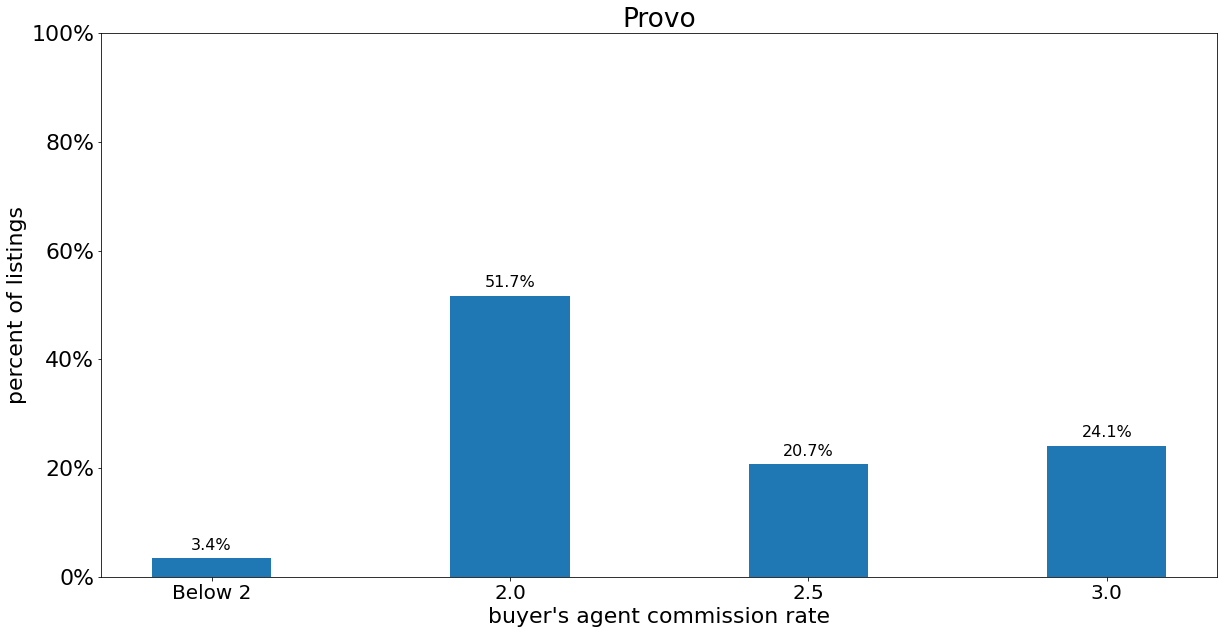

798
remaining percentage 1.127819548872182


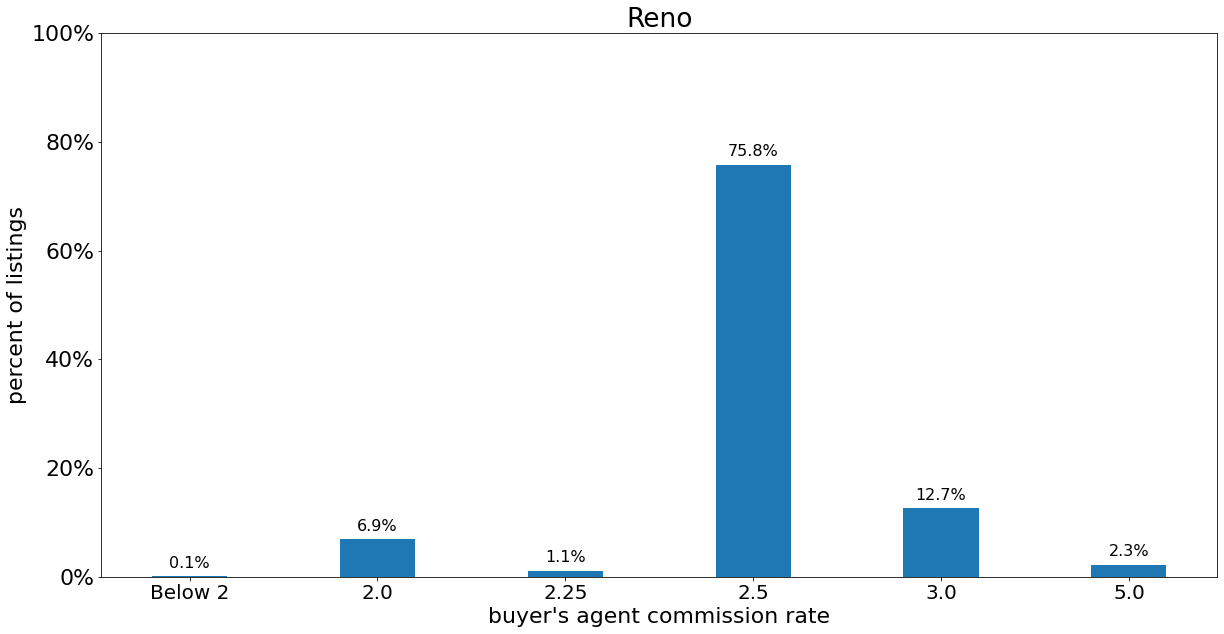

7266
remaining percentage 1.8717313515001308


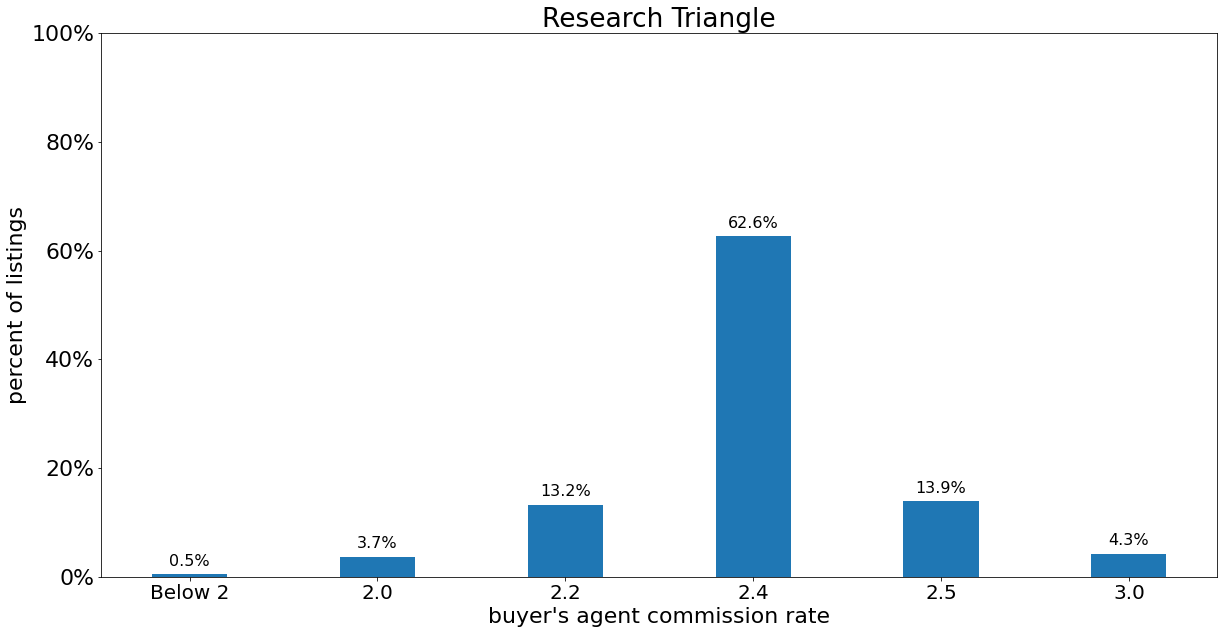

43966
remaining percentage 1.9969976800254727


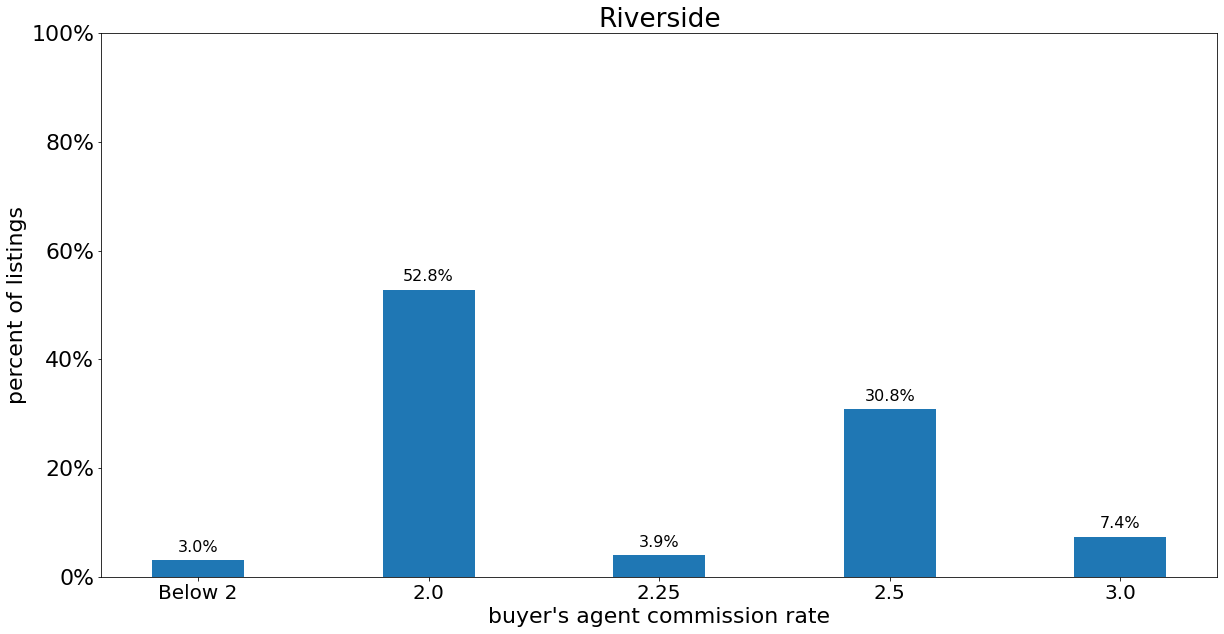

514
remaining percentage 1.361867704280158


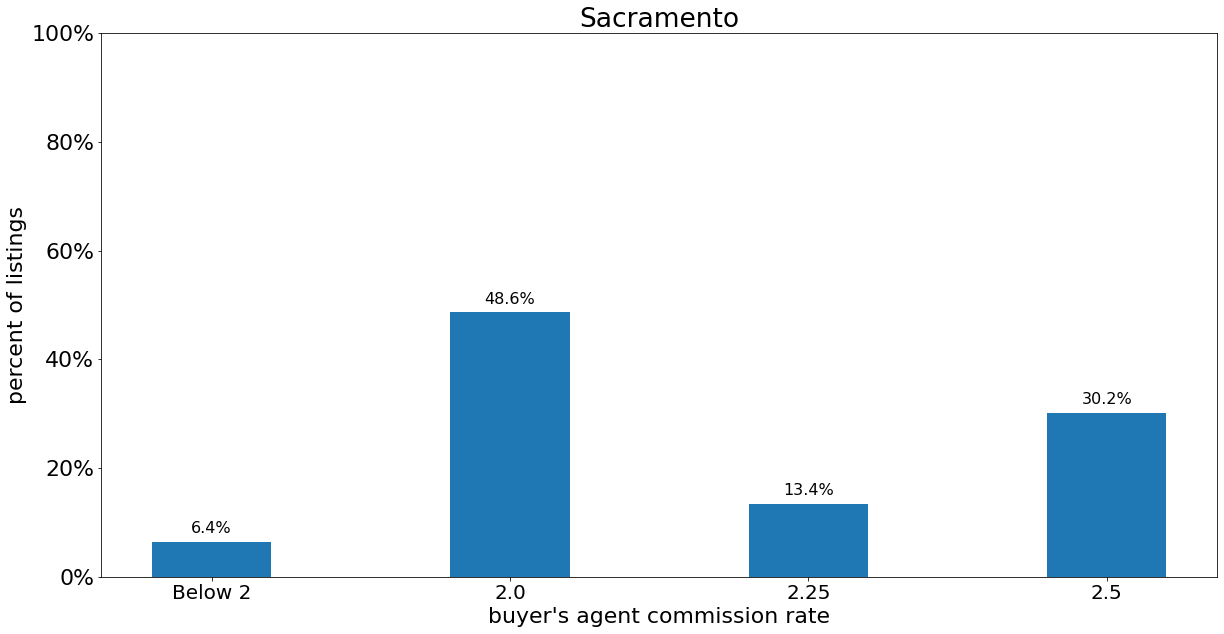

164
remaining percentage 0.0


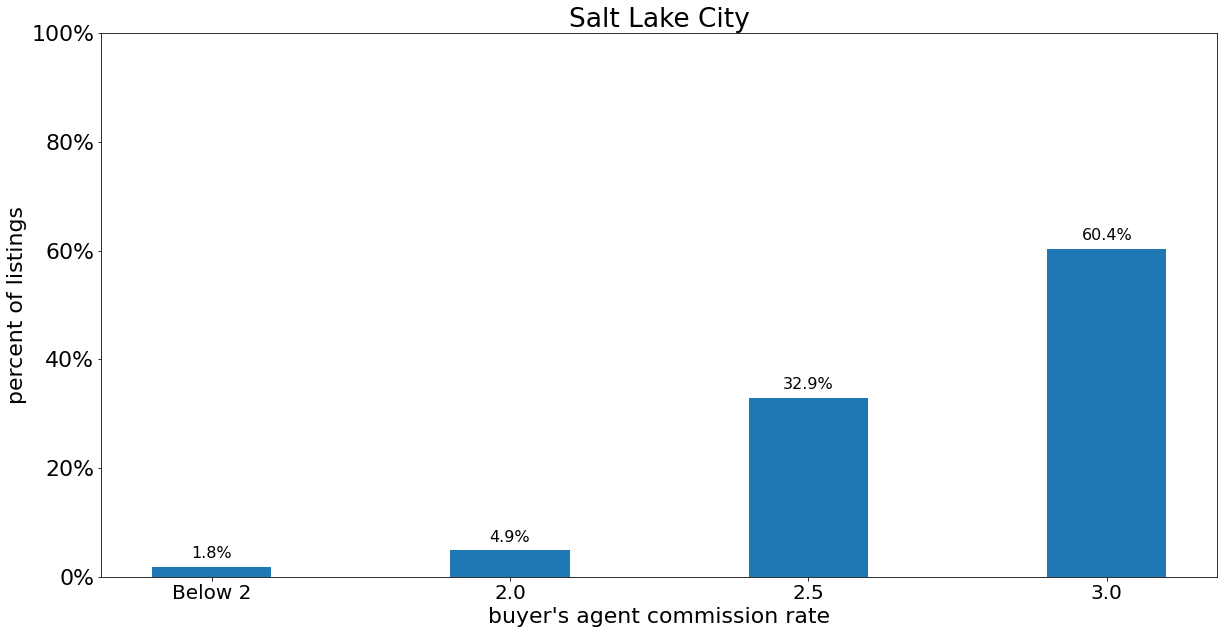

1904
remaining percentage 0.3151260504201616


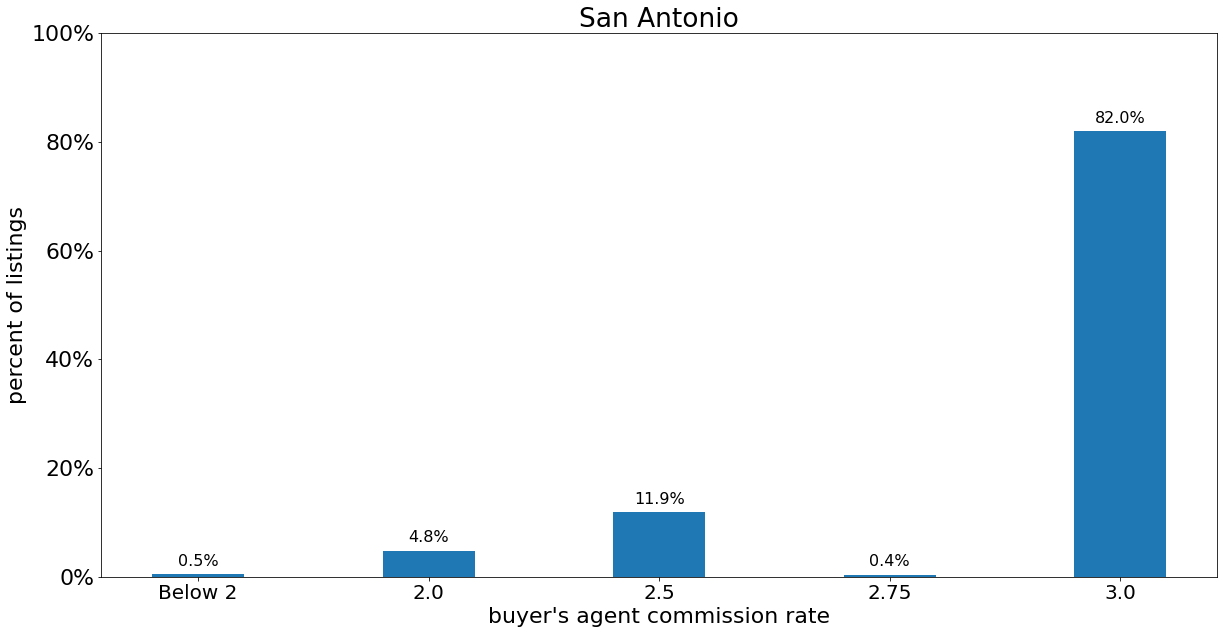

14509
remaining percentage 1.199255634433797


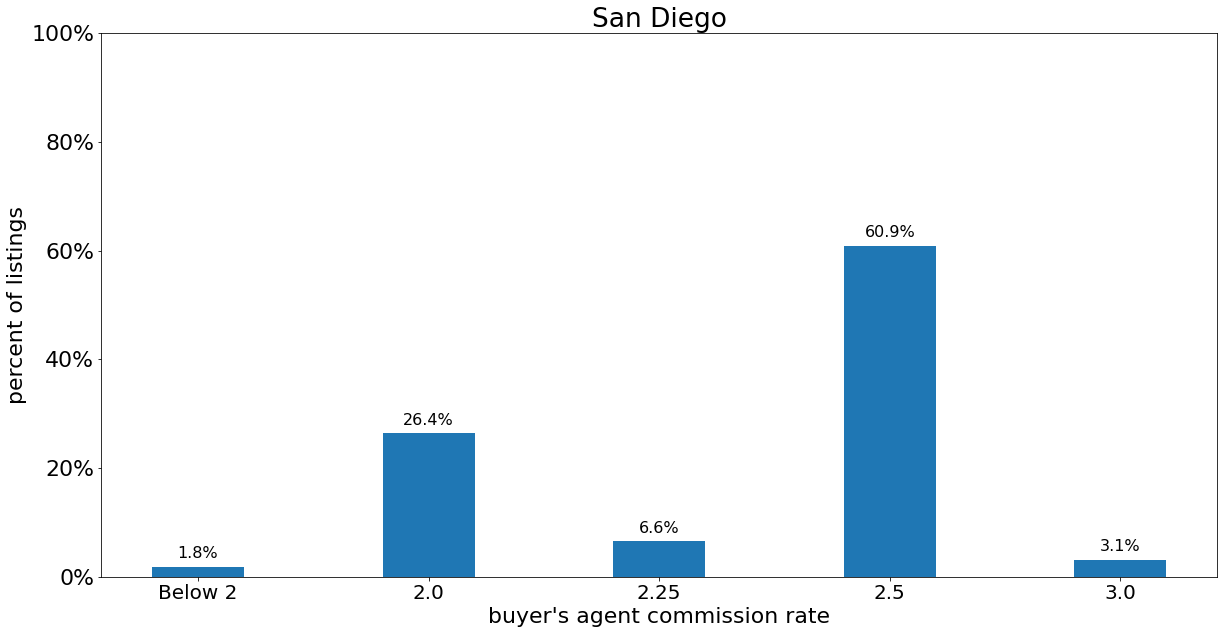

2643
remaining percentage 0.8702232311766807


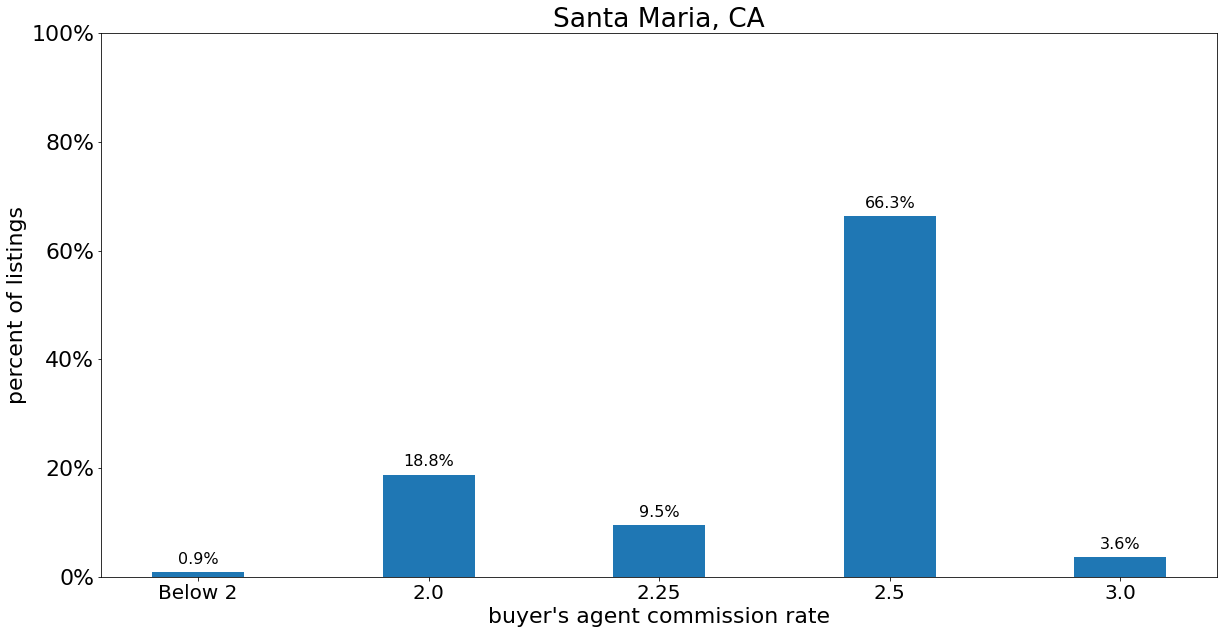

36168
remaining percentage 0.36496350364961927


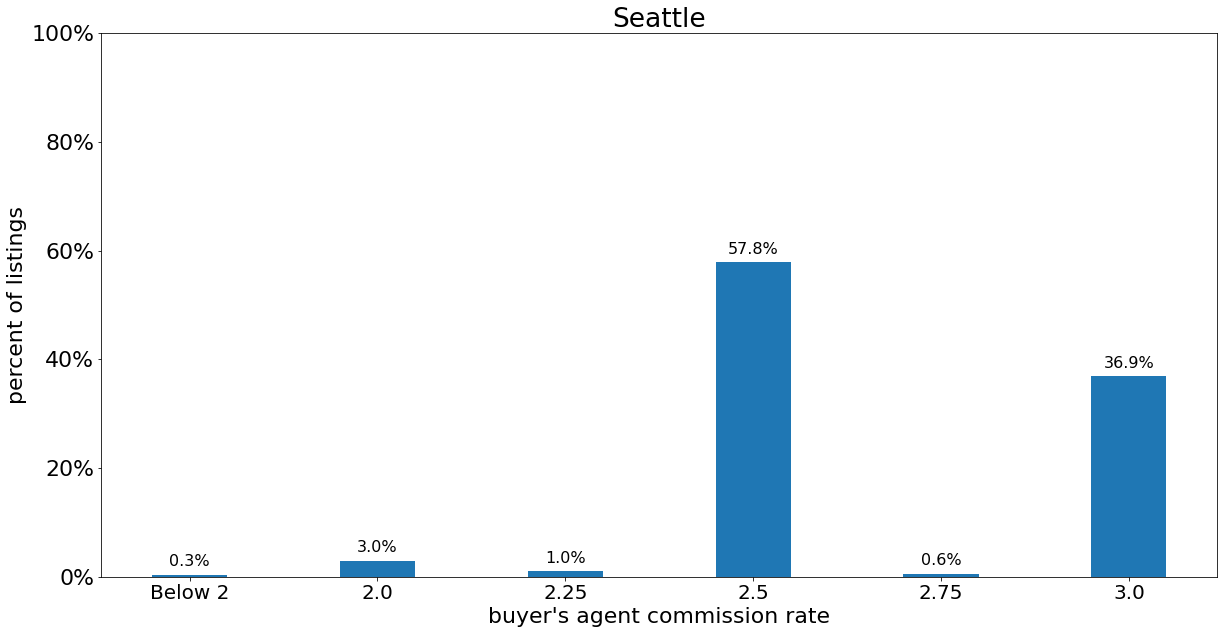

19458
remaining percentage 4.19364785692261


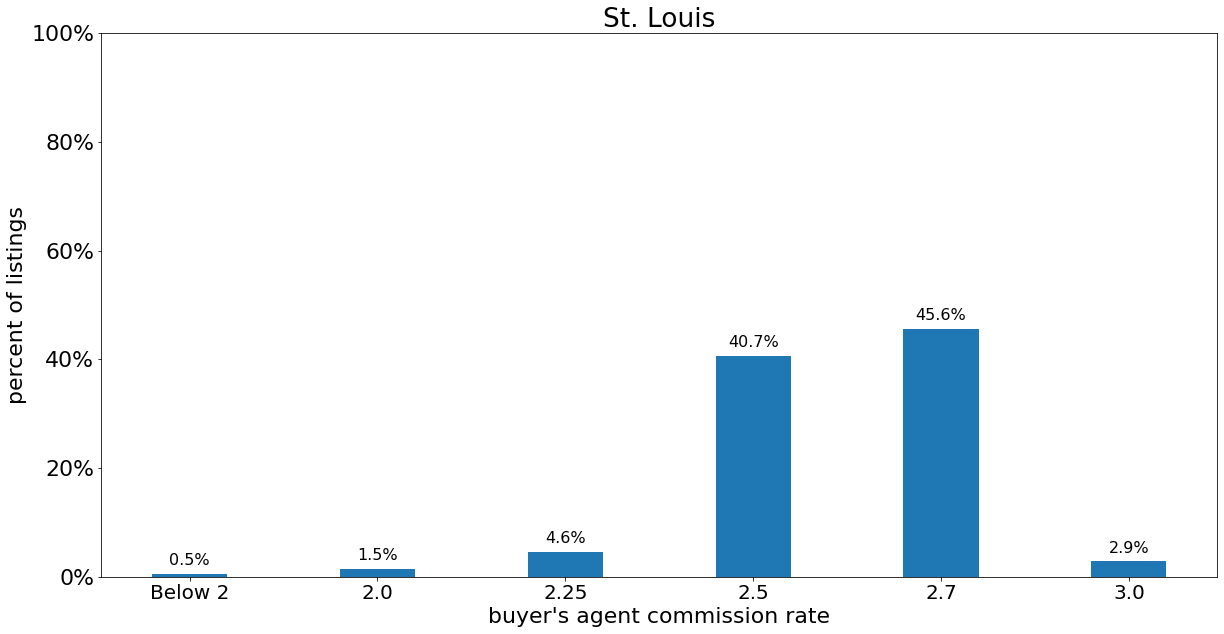

124
remaining percentage 0.8064516129032313


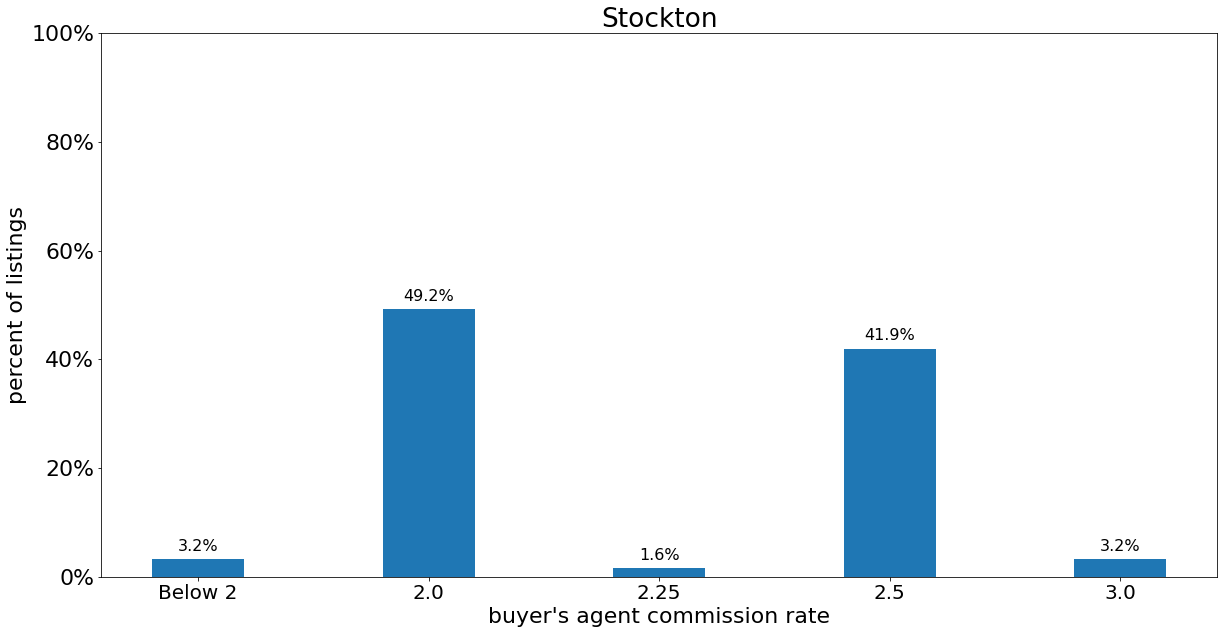

2720
remaining percentage 45.992647058823536


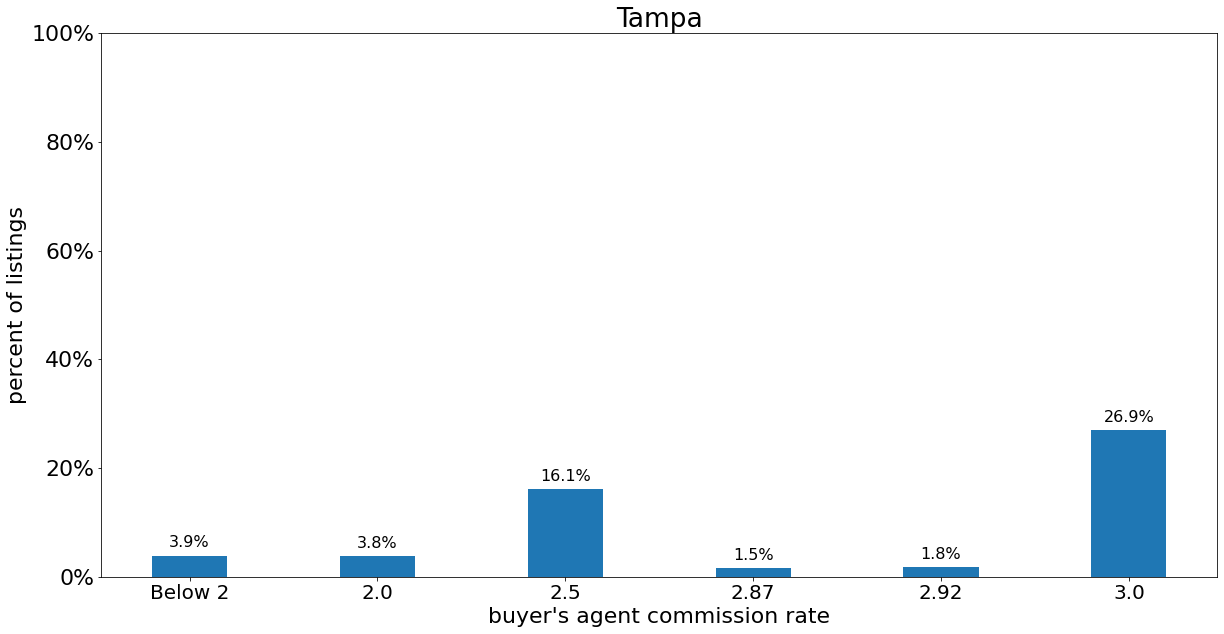

13104
remaining percentage 0.6715506715506621


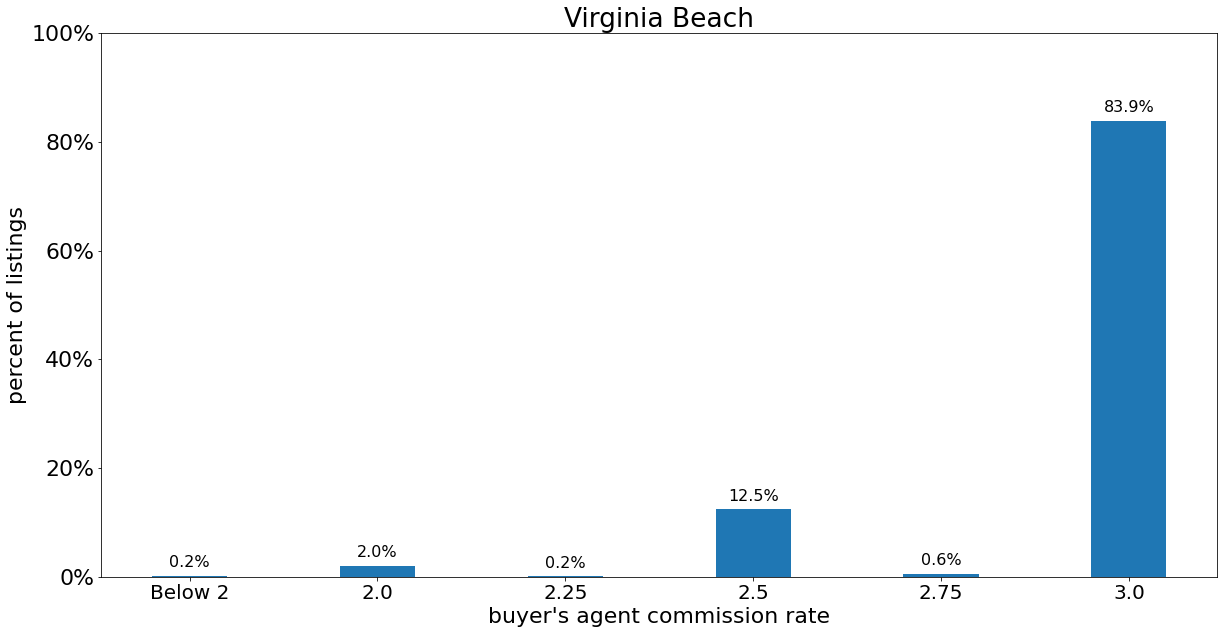

25849
remaining percentage 0.9710240241402062


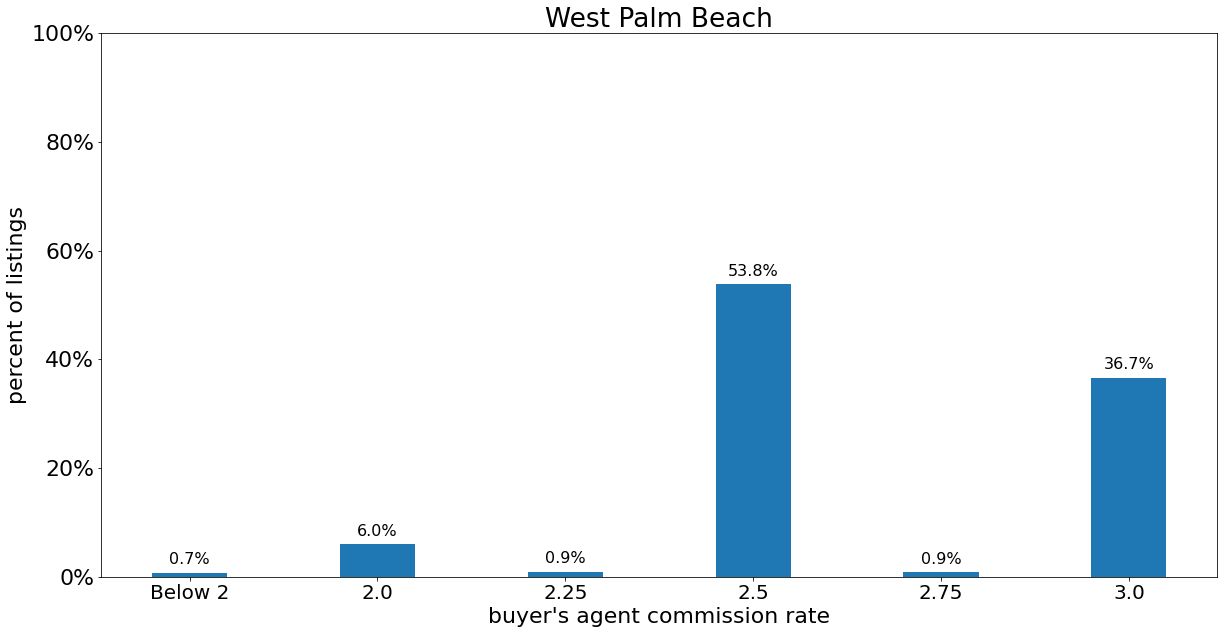

4996
remaining percentage 16.212970376301044


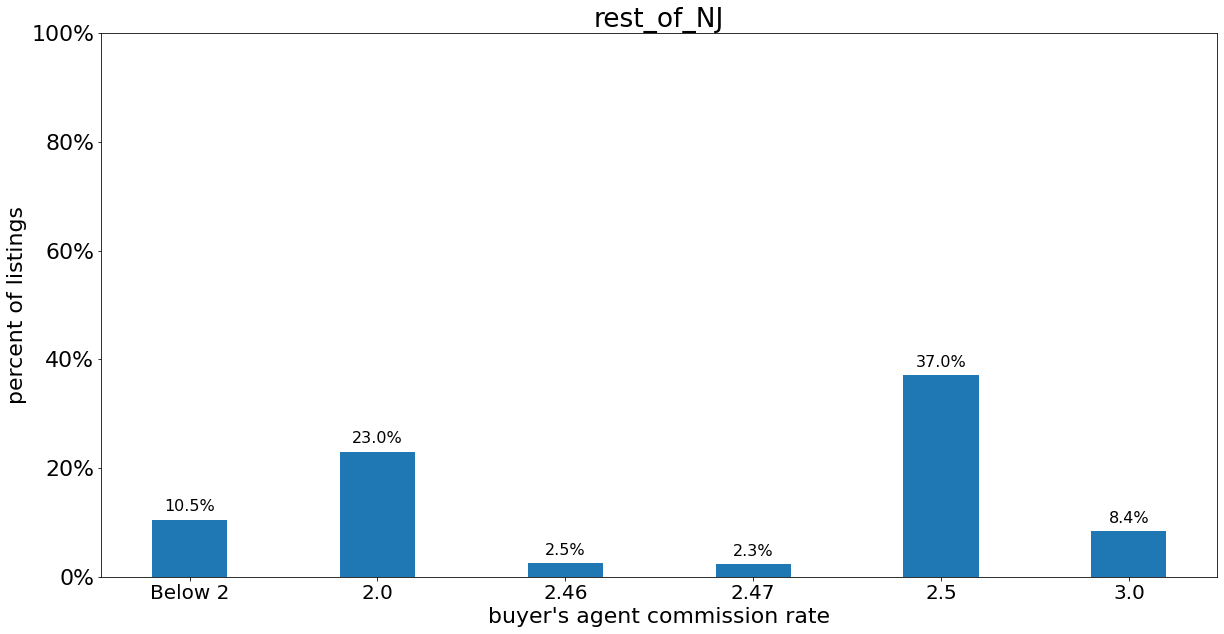

In [49]:
for market_area in np.sort(buyer_commission_df_nonnull_f['market_area'].unique()):
    get_distribution_for_market(market_area)

In [50]:
def get_distribution_for_market_colored(market_area, cutoffs, state=None, top_rates=5):
    comm_rates = buyer_commission_df_nonnull_f[
        buyer_commission_df_nonnull_f['market_area'] == market_area]['buyside_commission']
    comm_fracs = comm_rates.value_counts() / len(comm_rates)
    top_comm_pcts = 100 * comm_fracs.iloc[:top_rates]
    top_comm_pcts = top_comm_pcts.loc[top_comm_pcts.index >= 2]
    top_comm_pcts.sort_index(inplace=True)
    top_comm_rates = list(top_comm_pcts.index)
    below_2_pct = 100 * (comm_rates < 2).sum() / len(comm_rates)
    top_comm_pcts_lst = top_comm_pcts.tolist()
    all_pcts = [below_2_pct] + top_comm_pcts_lst
    remaining_pct = 100 - np.sum(all_pcts)
    print('remaining percentage', remaining_pct)

    plt.figure(figsize=(20, 10))
    x_locs = np.arange(len(top_comm_rates) + 1)
    
    colors = ['r']
    for top_comm_rate in top_comm_rates:
        if top_comm_rate >= cutoffs[0]:
            colors.append('g')
        elif len(cutoffs) > 1 and top_comm_rate >= cutoffs[1]:
            colors.append('y')
        elif top_comm_rate >= 2:
            colors.append('orange')    
    bar_plot = plt.bar(x_locs, all_pcts, width=0.4, color=colors)
    plt.xticks(x_locs, ['Below 2'] + top_comm_rates, fontsize=20)
    plt.xlabel("buyer's agent commission rate")
    plt.ylabel('percent of listings')
    plt.ylim((0, 100))
    plt.gca().set_yticklabels([f'{x/100:.0%}' for x in plt.gca().get_yticks()]) 
    market = market_area
    if state:
        market += f', {state}'
    plt.title(market)
    
    for idx, rect in enumerate(bar_plot):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + 1,
                 f'{round(all_pcts[idx], 1)}%',
                 ha='center', va='bottom', rotation=0, fontsize=16)
    
    if len(cutoffs) == 1:
        if cutoffs[0] == 2:
            colors = {'at least going rate':'g', 
                  'below 2%': 'r'} 
        else:
            colors = {'at least going rate':'g', 
                      'at least 2%':'orange',
                      'below 2%': 'r'} 
    else:
        colors = {'at least going rate':'g', 
                  'just below going rate': 'y',
                  'at least 2%':'orange',
                  'below 2%': 'r'} 
        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    
    plt.show()

remaining percentage 0.7756653992395428


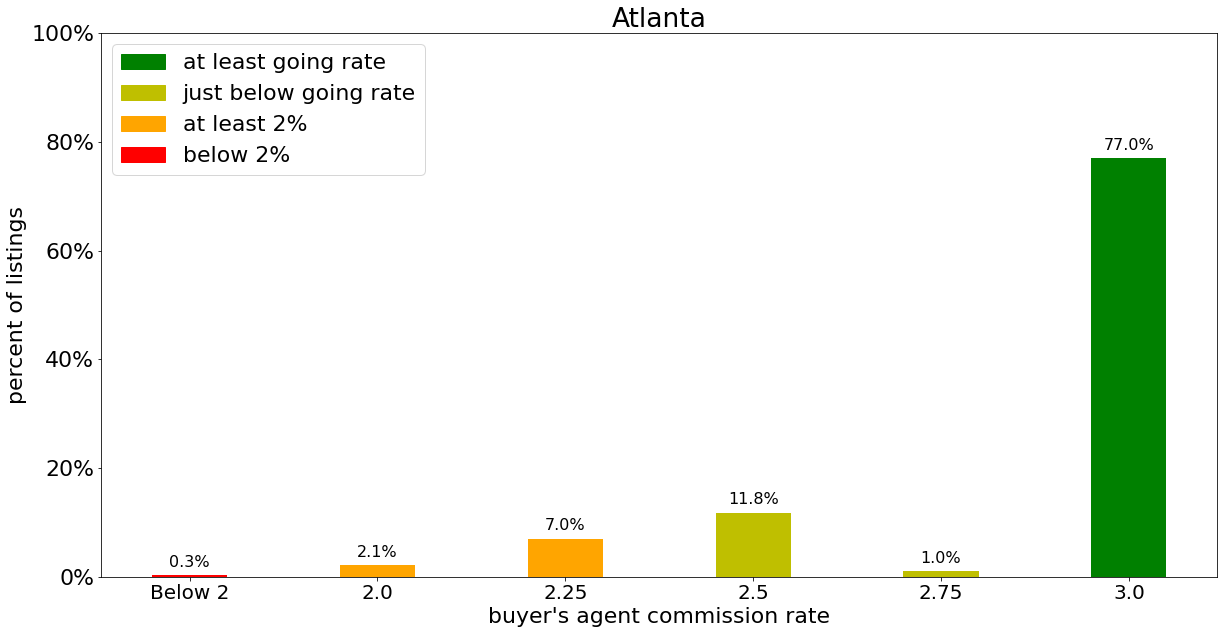

In [51]:
get_distribution_for_market_colored('Atlanta', [3.0, 2.5])

remaining percentage 0.781572465215362


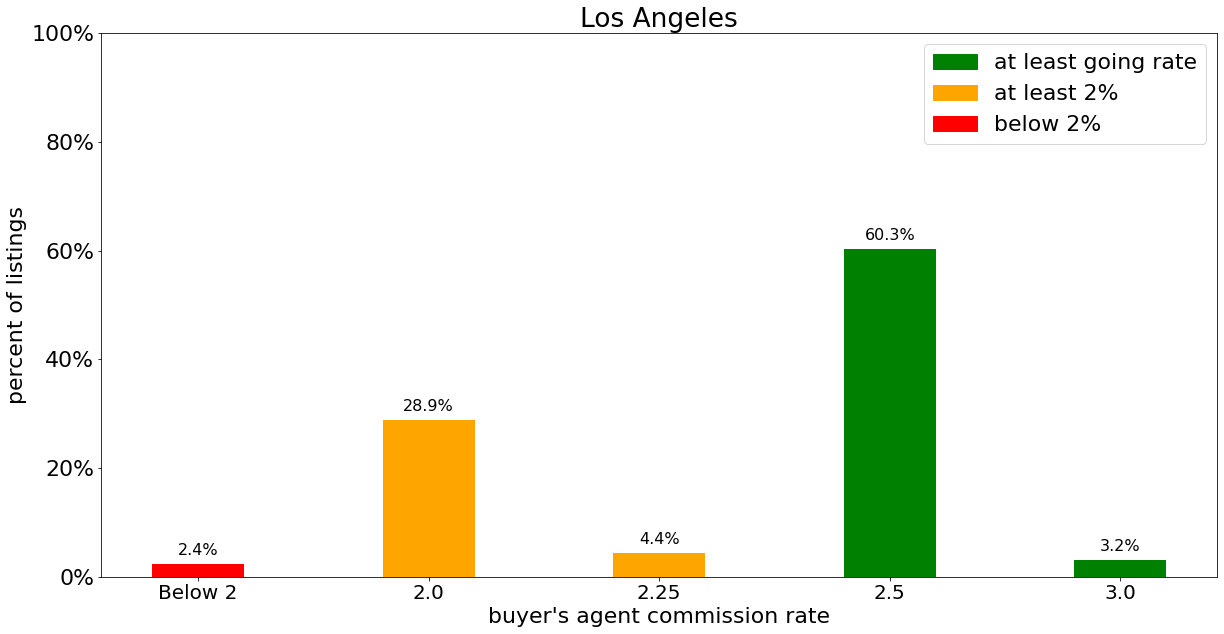

In [52]:
get_distribution_for_market_colored('Los Angeles', [2.5])

remaining percentage 0.2915515805164546


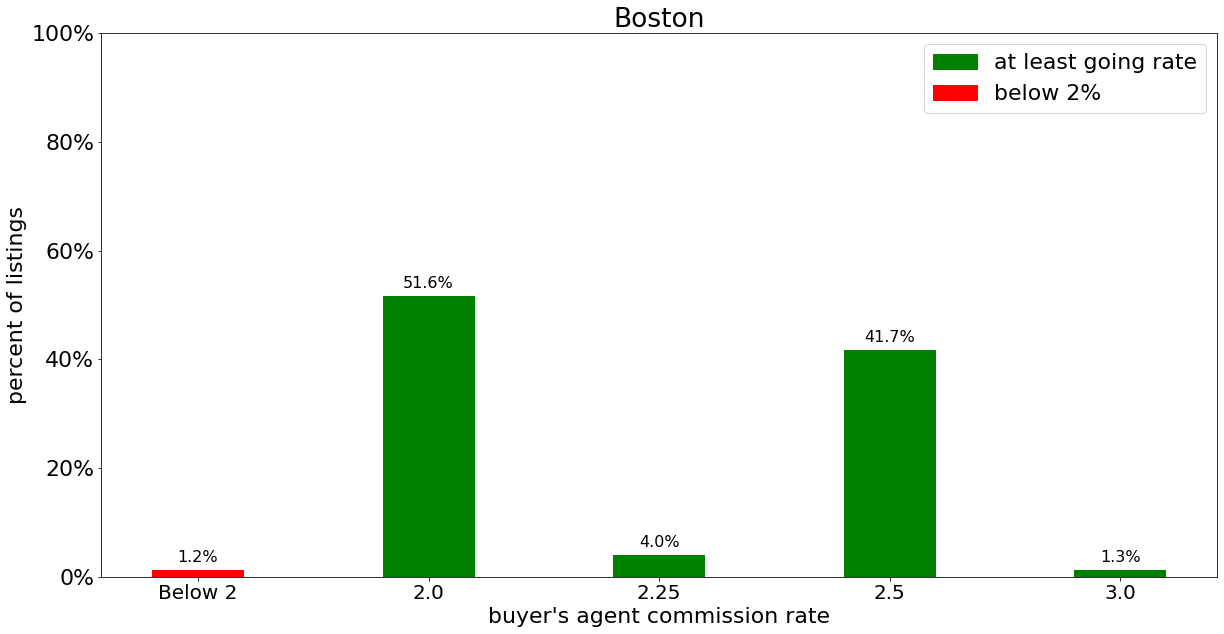

In [53]:
get_distribution_for_market_colored('Boston', [2.0])